In [1]:
import pandas as pd
import re
import os
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df_o = pd.read_csv("logbook_assignment1.csv", dtype=str, encoding='utf-8', low_memory=False)
df = df_o.copy()
df_o.info()
df_o.head()
OUTPUT_PLOTS_DIR = "plots_numeric"
os.makedirs(OUTPUT_PLOTS_DIR, exist_ok=True)

# # --- Date columns ---
# df['date_fueled'] = pd.to_datetime(df['date_fueled'], format="%b %d %Y", errors="coerce")
# df['date_captured'] = pd.to_datetime(df['date_captured'], format="%b %d %Y", errors="coerce")

# # --- Helper function to clean numbers with commas/thousands separators ---
# def clean_numeric(series):
#     return (
#         series.astype(str)                      # ensure string
#         .str.replace(",", "", regex=False)      # remove commas
#         .str.strip()                            # strip whitespace
#     )

# # --- Odometer, gallons, miles ---
# df['odometer'] = pd.to_numeric(clean_numeric(df['odometer']), errors="coerce")
# df['gallons']  = pd.to_numeric(clean_numeric(df['gallons']), errors="coerce")
# df['miles']    = pd.to_numeric(clean_numeric(df['miles']), errors="coerce")

# # --- Costs: remove currency symbols & commas, then convert ---
# df['cost_per_gallon'] = (
#     df['cost_per_gallon']
#     .astype(str)
#     .str.replace(r"[^\d\.\,]", "", regex=True)   # keep only digits, dots, commas
#     .str.replace(",", "", regex=False)           # remove commas if present
# )
# df['cost_per_gallon'] = pd.to_numeric(df['cost_per_gallon'], errors="coerce")

# df['total_spent'] = (
#     df['total_spent']
#     .astype(str)
#     .str.replace(r"[^\d\.\,]", "", regex=True)
#     .str.replace(",", "", regex=False)
# )
# df['total_spent'] = pd.to_numeric(df['total_spent'], errors="coerce")

# # --- Other numeric fields ---
# df['mpg'] = pd.to_numeric(df['mpg'], errors="coerce")

# df['user_url'] = df['user_url'].astype(str) 

# df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174870 entries, 0 to 1174869
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   date_fueled      1125665 non-null  object
 1   date_captured    1174870 non-null  object
 2   odometer         1025716 non-null  object
 3   gallons          1100660 non-null  object
 4   cost_per_gallon  1094110 non-null  object
 5   total_spent      1100660 non-null  object
 6   mpg              1100660 non-null  object
 7   miles            146274 non-null   object
 8   user_url         1174870 non-null  object
dtypes: object(9)
memory usage: 80.7+ MB


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


# Date Fields
## Identify what percentage of date fueled entries that are not proper dates.[1]


In [2]:
#1.1 Cleaning:Date Fields
from dateutil.parser import parse
import warnings
from dateutil.parser._parser import UnknownTimezoneWarning

warnings.filterwarnings("ignore", category=UnknownTimezoneWarning)

#returns true if the entry is in a date format 
def validdate(s):
    if not isinstance(s, str) or not s.strip():
        return False
    try:
        parse(s, dayfirst=False,yearfirst=False,fuzzy=False)
        return True
    except Exception:
        return False

total = len(df)
invalid = (~df["date_fueled"].map(validdate)).sum()
invalidtotal= (invalid / total) * 100
print(f"Total dates: {total}")
print(f"Invalid dates: {invalid}")
print(f"Percentage of invalid dates: {invalidtotal:.3f}%")


Total dates: 1174870
Invalid dates: 135137
Percentage of invalid dates: 11.502%


## If date fueled is not entered correctly (or is not a date), and the date captured is a valid date, then fill in this value as a proxy. [1]


In [3]:
#1.2

fueled_list = df["date_fueled"].astype(str).tolist() #convert the 'date_fueled' column to a list of strings
captured_list = df["date_captured"].astype(str).tolist()
#keeps track of how many rows we fix
replaced_count = 0

for i in range(len(fueled_list)):
    if not validdate(fueled_list[i]):    #check if current fueled val is invalid
        if validdate(captured_list[i]):      #if fueled is invalid, check if captured is valid
            fueled_list[i] = captured_list[i]    #If captured is valid, replace fueled with captured/replace with proxy 
            replaced_count += 1 #increase the counter since we fixed one row
#update the DataFrame with the fixed fueled_lis
df["date_fueled"] = fueled_list

print(f"Rows filled from date_captured: {replaced_count}") #replacements made
print("valid fueled:", df["date_fueled"].map(validdate).sum()) #entries in the final date_fueled column are valid
print("valid captured:", df["date_captured"].map(validdate).sum())#entries in the date_captured column are valid
df.head()

Rows filled from date_captured: 135137
valid fueled: 1174870
valid captured: 1174870


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,Apr 7 2022,Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


##  Convert the column to a date format, setting any invalid date fueled entries to NaT. [2]

In [4]:
#1.3

df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

#count invalids (NaT)
total = len(df)
nat_count = df["date_fueled_dt"].isna().sum()
print(f"entries converted to NaT: {nat_count} ({nat_count/total:.2%})")
df.head()

entries converted to NaT: 2073 (0.18%)


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...,2022-02-15


In [5]:

# #remove later
# mask_validator_ok = df["date_fueled"].map(validdate)
# mask_pandas_nat   = df["date_fueled_dt"].isna()
# off_by_pandas = df.loc[mask_validator_ok & mask_pandas_nat, "date_fueled"].head(20)
# print("Validator OK but pandas NaT (samples):")
# print(off_by_pandas.to_list())

# print(df.loc[mask_validator_ok & mask_pandas_nat, "_date_fueled_raw"].head(20).to_list())


# print({
#     "validator_invalid": int((~mask_validator_ok).sum()),
#     "pandas_NaT": int(mask_pandas_nat.sum()),
#     "validator_ok_but_pandas_NaT": int((mask_validator_ok & mask_pandas_nat).sum())
# })


## Remove dates that are in the future, or dates that are earlier than 2005.[1]

In [6]:
#1.4
lower = pd.Timestamp("2005-01-01")
upper= pd.Timestamp.today().normalize()  #today's date

#True if inside the valid range)
mask = df["date_fueled_dt"].between(lower, upper, inclusive="both")

#filter the dataframe
before = len(df)
df = df[mask].copy()
after = len(df)

#many were dropped
print(f"Removed rows outside [{lower.date()} .. {upper.date()}]: {before - after}")
print(f"Rows remaining: {after}")




Removed rows outside [2005-01-01 .. 2025-09-07]: 2643
Rows remaining: 1172227


## Plot the distribution of fueling dates and comment on the results. [2]

Date range (after cleaning): 2005–2025
Peak year: 2021  (count = 340217)
Share of records in the last 5 years: 45.1%
Most common month number: 3 (1=Jan, 12=Dec)


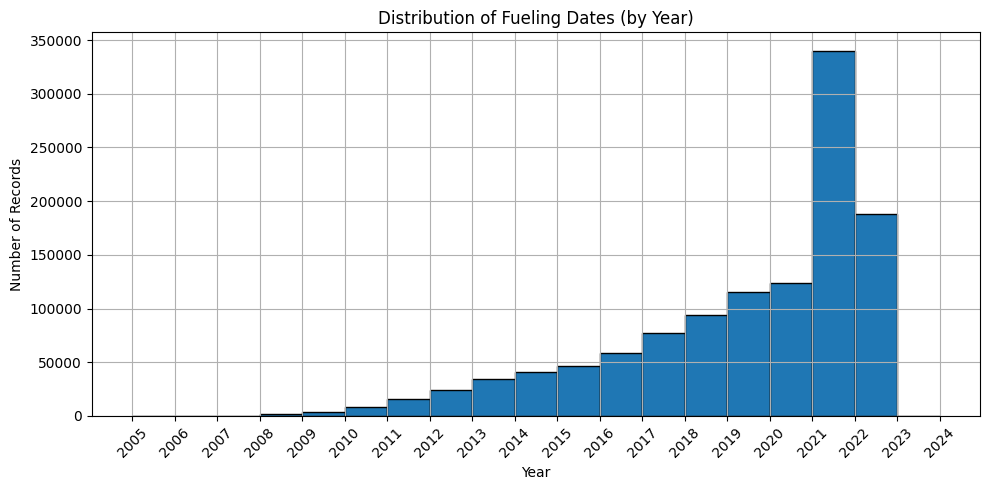

In [7]:
#1.5

#Make sure we have a datetime column
DATE_COL = "date fueled" if "date fueled" in df.columns else "date_fueled"
if "date_fueled_dt" not in df.columns:
    df["date_fueled_dt"] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=False)

#keep only valid datetimes
dates = df["date_fueled_dt"].dropna()

years = dates.dt.year
months = dates.dt.month

year_counts = years.value_counts().sort_index()
month_counts = months.value_counts().sort_index()

start_year = int(years.min()) if not years.empty else None
end_year   = int(years.max()) if not years.empty else None

top_year = int(year_counts.idxmax()) if not year_counts.empty else None
top_year_n = int(year_counts.max()) if not year_counts.empty else 0

#last 5 yrs
if not years.empty:
    last5_mask = years >= (years.max() - 4)
    share_last5 = last5_mask.mean() * 100
else:
    share_last5 = 0.0

peak_month = int(month_counts.idxmax()) if not month_counts.empty else None
print(f"Date range (after cleaning): {start_year}–{end_year}")
print(f"Peak year: {top_year}  (count = {top_year_n})")
print(f"Share of records in the last 5 years: {share_last5:.1f}%")
print(f"Most common month number: {peak_month} (1=Jan, 12=Dec)")


if not years.empty:
    plt.figure(figsize=(10, 5))
    # use integer bins from min to max (+1 to close the last bin)
    bins = range(int(years.min()), int(years.max()))
    years.hist(bins=bins, edgecolor="black")
    plt.title("Distribution of Fueling Dates (by Year)")
    plt.xlabel("Year")
    plt.ylabel("Number of Records")
    plt.xticks(range(start_year, end_year), rotation=45)  # show all years
    plt.tight_layout()
    plt.show()

Comment on distribution of fueling dates: There seems to be an exponential growth in the number of fueling which suggests that there may be more cars/users added to the dataset that are contributing to the increasing number of fuelings every year. We also notice a large jump in fuelings in 2021 from 2020 which seems to be an outlier, this may point to some data inaccuracy since 2021 was during peak COVID 19 lockdown, so we would expect there to be a decrease in the number of fueling records.

# 1.2 Numeric Fields

In [8]:
#1.2 Helper Functions
def clean_numeric_series(s: pd.Series) -> pd.Series:
    """Remove common non-numeric characters and convert to float.

    Handles: commas (thousand separators), currency symbols, spaces,
    parentheses for negatives, and empty strings. Returns a float Series
    with NaN where conversion fails.
    """
    # Work on a string copy and guard for non-strings
    s2 = s.astype(str).str.strip()
    # Replace non-breaking spaces
    s2 = s2.str.replace(r" ", "", regex=True)
    # Remove currency symbols and thousands separators
    s2 = s2.str.replace(r"[,$£€¥]", "", regex=True)
    # Detect parentheses representing negatives
    has_paren = s2.str.startswith("(") & s2.str.endswith(")")
    # Remove parentheses and any stray characters except - . e digits
    s2 = s2.str.replace(r"[()]", "", regex=True)
    s2 = s2.str.replace(r"[^0-9.\-eE]", "", regex=True)
    # Treat blanks / "nan" strings as missing
    s2 = s2.replace({'': None, 'None': None, 'nan': None, 'NaN': None})
    out = pd.to_numeric(s2, errors='coerce')
    # Reapply negative sign where parentheses existed
    if has_paren.any():
        out.loc[has_paren] = -out.loc[has_paren].abs()
    return out


def percent_missing(df: pd.DataFrame, columns: list) -> pd.Series:
    return df[columns].isna().mean() * 100

## Identify what percentage of gallons, miles, and odometer entries are missing. [3]

In [9]:
# --- 1.2: Numeric cleaning (drop-in) ---

import numpy as np

# Use the robust cleaner you defined (it removes currency, text, parentheses, etc.)
NUMERIC_COLS = [c for c in ['miles','gallons','mpg','odometer'] if c in df.columns]
for col in NUMERIC_COLS:
    df[col] = clean_numeric_series(df[col])

# Basic plausibility filters: set impossible values to NaN before imputation
# Tune thresholds if your instructor provided different ranges.
if 'gallons' in df.columns:
    df.loc[(df['gallons'] <= 0) | (df['gallons'] > 80), 'gallons'] = np.nan  # >80 US gal is vanishingly rare
if 'mpg' in df.columns:
    df.loc[(df['mpg'] <= 0) | (df['mpg'] > 200), 'mpg'] = np.nan             # 200 mpg is not realistic for cars
if 'miles' in df.columns:
    df.loc[df['miles'] < 0, 'miles'] = np.nan                                # negative distance impossible

# (Optional) re-compute missingness after true numeric parsing
cols_for_missing = [c for c in ['gallons','miles','odometer'] if c in df.columns]
missing_pct_after = percent_missing(df, cols_for_missing)
print("Missing % AFTER numeric cleaning:")
print(missing_pct_after)


Missing % AFTER numeric cleaning:
gallons      6.422476
miles       87.599927
odometer    12.645503
dtype: float64


## The miles, gallons and mpg columns are interdependent. If one is missing, the other two can be used to calculate it. [3]

In [10]:
# --- 1.2.2: Algebraic imputation ---

derived_df = df.copy()   # working copy; leaves df intact

def plausible_miles(x):   return (x > 0) & (x < 2000)     # per fill-up (tweak if needed)
def plausible_gallons(x): return (x > 0.1) & (x < 50)     # typical car fill-up range
def plausible_mpg(x):     return (x > 3) & (x < 120)      # common road-vehicle range

def safe_div(num, den):
    """Elementwise division that returns NaN on divide-by-zero or non-finite."""
    out = num / den
    out[~np.isfinite(out)] = np.nan
    return out

# Iterate a few times until no more fills
for iteration in range(6):
    changed = False

    have = set(derived_df.columns)
    if not {'miles','gallons','mpg'}.issubset(have):
        break

    # Compute candidates
    mpg_calc     = safe_div(derived_df['miles'], derived_df['gallons'])
    miles_calc   = derived_df['mpg'] * derived_df['gallons']
    gallons_calc = safe_div(derived_df['miles'], derived_df['mpg'])

    # Fill mpg where missing and candidate is plausible
    m = (
        derived_df['mpg'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_mpg(mpg_calc)
    )
    if m.any():
        derived_df.loc[m, 'mpg'] = mpg_calc[m]
        changed = True

    # Fill miles where missing and candidate is plausible
    m = (
        derived_df['miles'].isna()
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_miles(miles_calc)
    )
    if m.any():
        derived_df.loc[m, 'miles'] = miles_calc[m]
        changed = True

    # Fill gallons where missing and candidate is plausible
    m = (
        derived_df['gallons'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(gallons_calc)
    )
    if m.any():
        derived_df.loc[m, 'gallons'] = gallons_calc[m]
        changed = True

    print(f"Iteration {iteration+1}: changed={changed}")
    if not changed:
        break

derived_df.head()


Iteration 1: changed=True
Iteration 2: changed=False


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15


## The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value). [5]

In [11]:
# --- Sanity check & unit diagnostics ---

check_mask = (
    derived_df[['miles','gallons','mpg']].notna().all(axis=1)
    & plausible_miles(derived_df['miles'])
    & plausible_gallons(derived_df['gallons'])
    & plausible_mpg(derived_df['mpg'])
)

chk = derived_df.loc[check_mask, ['miles','gallons','mpg']].copy()
chk['expected_miles'] = chk['mpg'] * chk['gallons']

# Ignore tiny expected mileages (<5) to avoid exploding relative errors from rounding
chk = chk[chk['expected_miles'] >= 5]

# Relative error
chk['rel_err'] = (chk['miles'] - chk['expected_miles']).abs() / chk['expected_miles'].abs()

# Report
thr = 0.15  # 15% tolerance accommodates rounding and pump cut-offs; tighten later if you like
bad = chk[chk['rel_err'] > thr]
print(f"Sanity check: {len(chk) - len(bad)} / {len(chk)} "
      f"({(1 - len(bad)/max(len(chk),1)):.1%}) within {int(thr*100)}% tolerance.")
print(f"Median rel. err: {chk['rel_err'].median():.2%} | 95th pct: {chk['rel_err'].quantile(0.95):.2%}")

# --- Unit diagnostics ---
# If gallons were actually LITRES, expected_miles will be ~3.785x too large, so miles/expected ≈ 0.264.
# If miles were actually KILOMETRES, miles/expected ≈ 1.609.
# If BOTH (km & litres), miles/expected ≈ 1.609 / 3.785 ≈ 0.425 (or the inverse 6.09 depending on arrangement).
rat = chk['miles'] / chk['expected_miles']

def pct_between(a, lo, hi): 
    a = a.to_numpy()
    return (np.isfinite(a) & (a>=lo) & (a<=hi)).mean() * 100

print("Possible unit-mix fingerprints (share of checked rows):")
print(f"  ≈ litres-in-gallons (ratio ~0.264): {pct_between(rat, 0.24, 0.29):5.1f}%")
print(f"  ≈ kilometres-in-miles (ratio ~1.609): {pct_between(rat, 1.50, 1.70):5.1f}%")
print(f"  ≈ both km & litres (~0.425): {pct_between(rat, 0.39, 0.46):5.1f}%")
print(f"  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2): "
      f"{pct_between(rat, 0.78, 0.88) + pct_between(rat, 1.15, 1.25):5.1f}% (combined)")
derived_df.head()
derived_df.info()

Sanity check: 955962 / 957092 (99.9%) within 15% tolerance.
Median rel. err: 0.00% | 95th pct: 0.13%
Possible unit-mix fingerprints (share of checked rows):
  ≈ litres-in-gallons (ratio ~0.264):   0.0%
  ≈ kilometres-in-miles (ratio ~1.609):   0.0%
  ≈ both km & litres (~0.425):   0.0%
  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2):   0.0% (combined)
<class 'pandas.core.frame.DataFrame'>
Index: 1172227 entries, 0 to 1174869
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_fueled      1172227 non-null  object        
 1   date_captured    1172227 non-null  object        
 2   odometer         1023993 non-null  float64       
 3   gallons          1096941 non-null  float64       
 4   cost_per_gallon  1091571 non-null  object        
 5   total_spent      1098094 non-null  object        
 6   mpg              962196 non-null   float64       
 7   miles            957751 non-nul

##  Plot the distributions and comment on the distributions. [3]

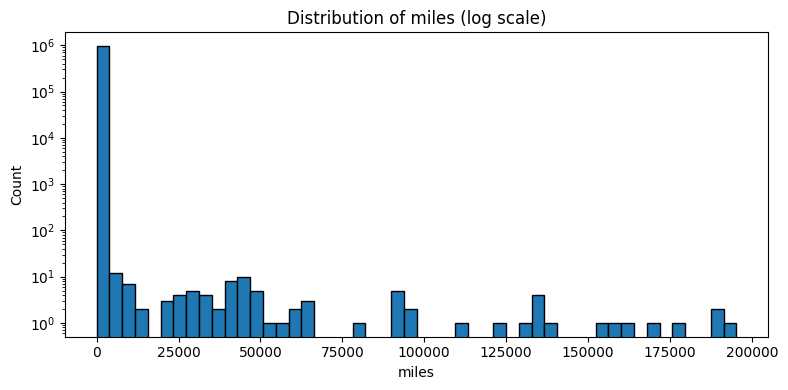

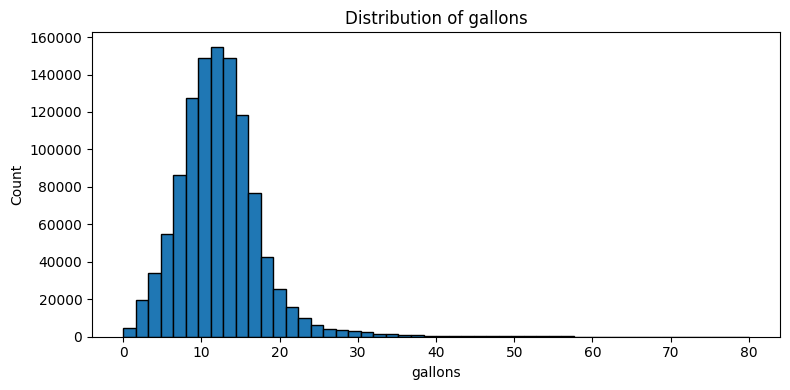

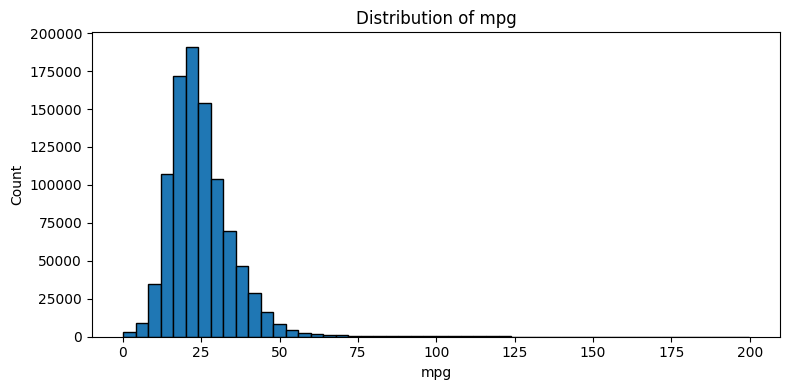

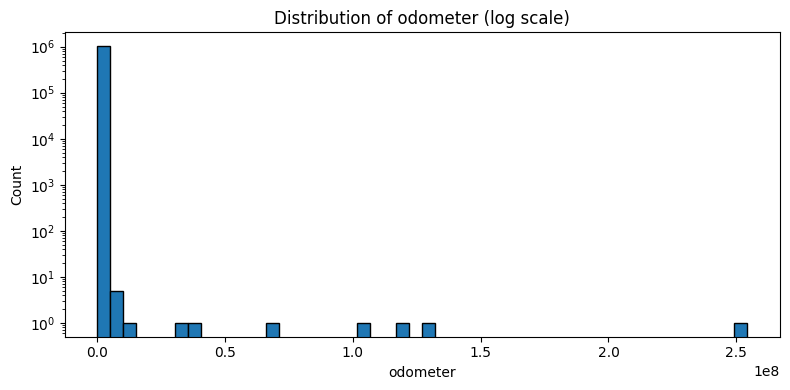

In [12]:
# 1.2.4 — Distribution plots for numeric columns
num_cols = [c for c in ['miles', 'gallons', 'mpg', 'odometer'] if c in derived_df.columns]

for col in num_cols:
    plt.figure(figsize=(8, 4))
    data = derived_df[col].dropna()

    # Use log scale if data is highly skewed
    if data.max() > 0 and data.median() > 0 and (data.max() / data.median()) > 50:
        plt.hist(data, bins=50, edgecolor="black", log=True)
        plt.yscale("log")
        plt.title(f"Distribution of {col} (log scale)")
    else:
        plt.hist(data, bins=50, edgecolor="black")
        plt.title(f"Distribution of {col}")

    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make sense? [3]

In [13]:
# 1.2.5 — Statistical summary
stats = derived_df[num_cols].describe().T
stats["most_frequent"] = [derived_df[c].mode().iloc[0] if not derived_df[c].mode().empty else None for c in num_cols]

print("Statistical summary of numeric columns:")
display(stats)

# Simple interpretation helper: flag suspicious values
for col in num_cols:
    col_stats = stats.loc[col]
    print(f"\nColumn: {col}")
    print(f"  Mean = {col_stats['mean']:.2f}, Std = {col_stats['std']:.2f}")
    print(f"  Min = {col_stats['min']}, Max = {col_stats['max']}")
    print(f"  Median (50%) = {col_stats['50%']:.2f}")
    print(f"  Most frequent = {col_stats['most_frequent']}")

    # Quick sanity checks
    if col == "mpg" and col_stats["max"] > 100:
        print(" Warning: MPG above 100 detected (likely bad entry).")
    if col == "odometer" and col_stats["min"] < 0:
        print(" Warning: Negative odometer readings detected.")


Statistical summary of numeric columns:


,count,mean,std,min,25%,50%,75%,max,most_frequent
miles,957751.0,302.894495,757.284939,0.100,219.4671,283.7408,354.654,195321.2,300.000
gallons,1096941.0,12.319848,5.440403,0.001,8.9920,11.9530,14.933,80.0,10.567
mpg,962196.0,25.156547,11.619624,0.100,18.2000,23.3000,29.800,199.7,21.000
odometer,1023993.0,104001.372196,340798.478033,0.000,45926.0000,91882.0000,146923.000,254362100.0,1.000



Column: miles
  Mean = 302.89, Std = 757.28
  Min = 0.1, Max = 195321.2
  Median (50%) = 283.74
  Most frequent = 300.0

Column: gallons
  Mean = 12.32, Std = 5.44
  Min = 0.001, Max = 80.0
  Median (50%) = 11.95
  Most frequent = 10.567

Column: mpg
  Mean = 25.16, Std = 11.62
  Min = 0.1, Max = 199.7
  Median (50%) = 23.30
  Most frequent = 21.0

Column: odometer
  Mean = 104001.37, Std = 340798.48
  Min = 0.0, Max = 254362100.0
  Median (50%) = 91882.00
  Most frequent = 1.0


In [14]:
# Commit imputed values back to main dataframe
df = derived_df.copy()
df.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15


#  Feature Engineering

## Create a new column with the currency. (Something to keep in mind is that the Swiss Franc has a period in the abbreviation). [2]


In [15]:
#2a.1

df["currency"] = df["cost_per_gallon"].astype("string").str.extract(r'^([^\d]+)') #gets everything up to the first number, then get currency
print(df[[ "currency"]].head(15)) # first 15 rows of the new currency column 
print(df["currency"].unique()) #all unique values found in the currency column

   currency
0      <NA>
1         $
2         £
3         £
4         $
5         $
6         $
7         $
8      <NA>
9         $
10      RON
11        $
12        $
13        $
14        €
<StringArray>
[  <NA>,    '$',    '£',  'RON',    '€',   'zł',  'AU$',    '₩',   'Ft',
  'NZ$',
 ...
   'Bs', 'NAf.',  'KZT',   'YR',  'MAD',  'CV$',  'IQD',  'CU$',  'KGS',
   'L$']
Length: 122, dtype: string


## Create a new column containing the float value of the total spend and the cost per gallon. (Swiss Franc comment as above). [2]

In [16]:
#2a.2
#gets rid of non-numeric characters (keep digits, dot, comma)
def to_float(s):
    if not isinstance(s, str):
        return None
    #remove currency symbols, keep digits, commas
    num = re.sub(r"[^\d.,]", "", s)
    #replace comma with nothing 
    num = num.replace(",", "")
    try:
        return float(num) if num else None
    except ValueError:
        return None
df["cost_per_gallon_float"] = df["cost_per_gallon"].astype("string").apply(to_float)
df["total_spent_float"]     = df["total_spent"].astype("string").apply(to_float)

print(df[["cost_per_gallon", "cost_per_gallon_float",
          "total_spent", "total_spent_float"]].head(10))

  cost_per_gallon  cost_per_gallon_float total_spent  total_spent_float
0             NaN                    NaN         NaN                NaN
1          $5.599                  5.599      $67.86              67.86
2           £5.45                  5.450      £43.53              43.53
3           £5.11                  5.110      £54.00              54.00
4          $3.029                  3.029      $35.29              35.29
5          $3.739                  3.739      $12.76              12.76
6          $4.639                  4.639      $41.96              41.96
7          $2.929                  2.929      $43.82              43.82
8             NaN                    NaN         NaN                NaN
9          $1.999                  1.999       $5.42               5.42


## Car make, model, year, User ID: use the url (the last value in the URL is the user ID) [4]

In [17]:
#2.3
parts = df["user_url"].str.split("/", expand=True)

df["make"]    = parts[3].astype("string")
df["model"]   = parts[4].astype("string")
df["year"]    = pd.to_numeric(parts[5], errors="coerce").astype("Int64")
df["user_id"] = parts[6].astype("string")  

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1172227 entries, 0 to 1174869
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date_fueled            1172227 non-null  object        
 1   date_captured          1172227 non-null  object        
 2   odometer               1023993 non-null  float64       
 3   gallons                1096941 non-null  float64       
 4   cost_per_gallon        1091571 non-null  object        
 5   total_spent            1098094 non-null  object        
 6   mpg                    962196 non-null   float64       
 7   miles                  957751 non-null   float64       
 8   user_url               1172227 non-null  object        
 9   date_fueled_dt         1172227 non-null  datetime64[ns]
 10  currency               1091571 non-null  string        
 11  cost_per_gallon_float  1089547 non-null  float64       
 12  total_spent_float      1096017 no

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt,currency,cost_per_gallon_float,total_spent_float,make,model,year,user_id
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,<NA>,NaN,NaN,suzuki,swift,2015,674857
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,$,5.599,67.86,bmw,x3,2009,461150
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,£,5.450,43.53,mercedes-benz,e300,1998,133501
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,£,5.110,54.00,bmw,320d,2010,247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15,$,3.029,35.29,honda,passport,2019,1038865


The data is given in imperial units, and in SA, we use proper measurement standards.
## litres filled: use the gallons - consider whether to use UK or US gallons. [2] km driven: use the miles driven to compute this. [1]litres per 100km: use the two new features to calculate this. [1]

In [18]:
# Step 1: convert gallons to litres (UK gallons)
df["litres_filled"] = df["gallons"] * 4.54609

# Step 2: convert miles to km
df["km_driven"] = df["miles"] * 1.60934

# Step 3: calculate litres per 100 km
df["litres_per_100km"] = (df["litres_filled"] / df["km_driven"]) * 100

df

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt,currency,cost_per_gallon_float,total_spent_float,make,model,year,user_id,litres_filled,km_driven,litres_per_100km
0,Apr 7 2022,Apr 7 2022,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,<NA>,NaN,NaN,suzuki,swift,2015,674857,NaN,NaN,NaN
1,Nov 7 2012,Aug 30 2016,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,$,5.599,67.86,bmw,x3,2009,461150,55.098611,616.364345,8.939292
2,Sep 22 2012,Sep 28 2012,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,£,5.450,43.53,mercedes-benz,e300,1998,133501,36.327805,366.516724,9.911636
3,May 4 2019,May 4 2019,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,£,5.110,54.00,bmw,320d,2010,247233,48.074902,796.478459,6.035932
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,2022-02-15,$,3.029,35.29,honda,passport,2019,1038865,52.966495,393.322696,13.466422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174865,Feb 19 2020,Feb 19 2020,118237.0,13.046,$1.999,$26.08,25.7,335.2822,https://www.somewebsite.com/volkswagen/beetle/...,2020-02-19,$,1.999,26.08,volkswagen,beetle,2005,388391,59.308290,539.583056,10.991503
1174866,Dec 6 2019,Dec 6 2019,141761.0,12.637,$2.449,$30.95,20.0,252.7400,https://www.somewebsite.com/toyota/avalon/2000...,2019-12-06,$,2.449,30.95,toyota,avalon,2000,432408,57.448939,406.744592,14.124082
1174867,Oct 4 2021,Oct 4 2021,65029.0,10.002,$3.449,$34.50,28.5,285.0570,https://www.somewebsite.com/fiat/500/2013/909694,2021-10-04,$,3.449,34.50,fiat,500,2013,909694,45.469992,458.753632,9.911636
1174868,Jul 26 2021,Jul 26 2021,15255.0,10.493,$3.539,$37.13,36.5,382.9945,https://www.somewebsite.com/mini/cooper/2019/9...,2021-07-26,$,3.539,37.13,mini,cooper,2019,952426,47.702122,616.368369,7.739223


# Vehicle Exploration

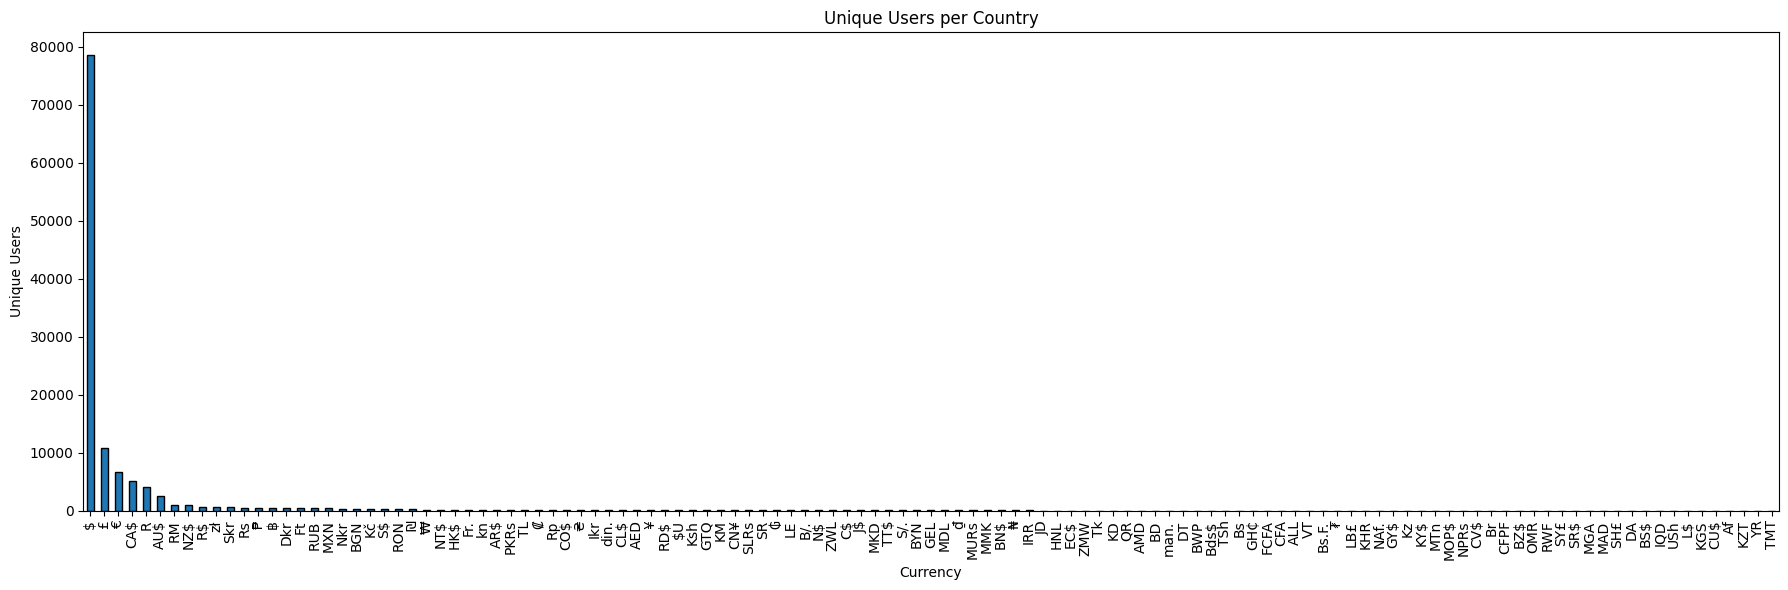

In [19]:
#3.1
df["user_id"] = (
    df["user_url"].astype("string").str.rstrip("/").str.split("/").str[-1]
)
# Currency: use existing if present; else extract from cost_per_gallon/total_spent
if "currency" not in df.columns:
    # prefer cost_per_gallon; fallback to total_spent
    src = df["cost_per_gallon"].astype("string").fillna(df["total_spent"].astype("string"))
    # capture everything before the first digit (handles S.Fr., NZ$, RON, $, £, €, etc.)
    df["currency"] = src.str.extract(r"^([^\d]+)", expand=False)

#count unique users per currency
#drop rows with missing user_id or currency for the count
counts = (
    df.dropna(subset=["user_id", "currency"])
      .groupby("currency")["user_id"]
      .nunique()
      .sort_values(ascending=False)
)

plt.figure(figsize=(18, 6))
counts.plot(kind="bar", edgecolor="black")
plt.title("Unique Users per Country")
plt.xlabel("Currency")
plt.ylabel("Unique Users")
plt.tight_layout()
plt.show()

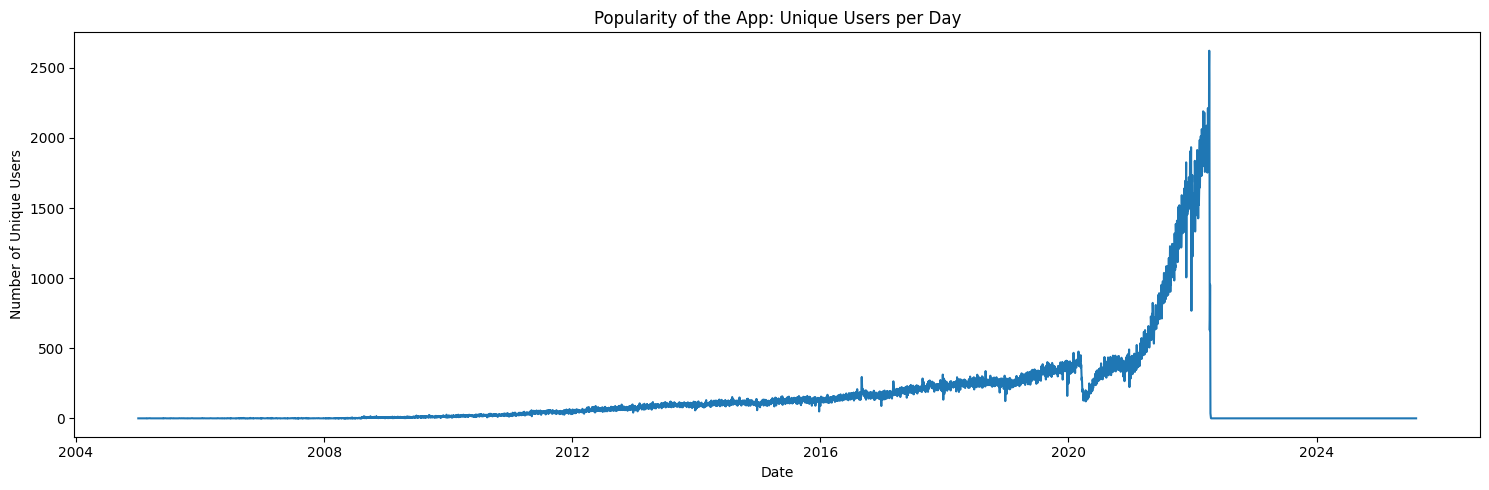

Date range: 2005-01-02 → 2025-08-09
Peak day: 2022-04-09 with 2622 unique users


In [20]:
#3.2- number of unique users per day
df["user_id"] = (
    df["user_url"].astype("string").str.rstrip("/").str.split("/").str[-1]
)
if "date_fueled_dt" not in df.columns:
    df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

#Group by day and count unique users 
usersperday = ( df.dropna(subset=["user_id", "date_fueled_dt"]).groupby(df["date_fueled_dt"].dt.date)["user_id"].nunique())
plt.figure(figsize=(15, 5))
usersperday.plot()
plt.title("Popularity of the App: Unique Users per Day")
plt.xlabel("Date")
plt.ylabel("Number of Unique Users")
plt.tight_layout()
plt.show()
print("Date range:", usersperday.index.min(), "→", usersperday.index.max())
print("Peak day:", usersperday.idxmax(), "with", usersperday.max(), "unique users")

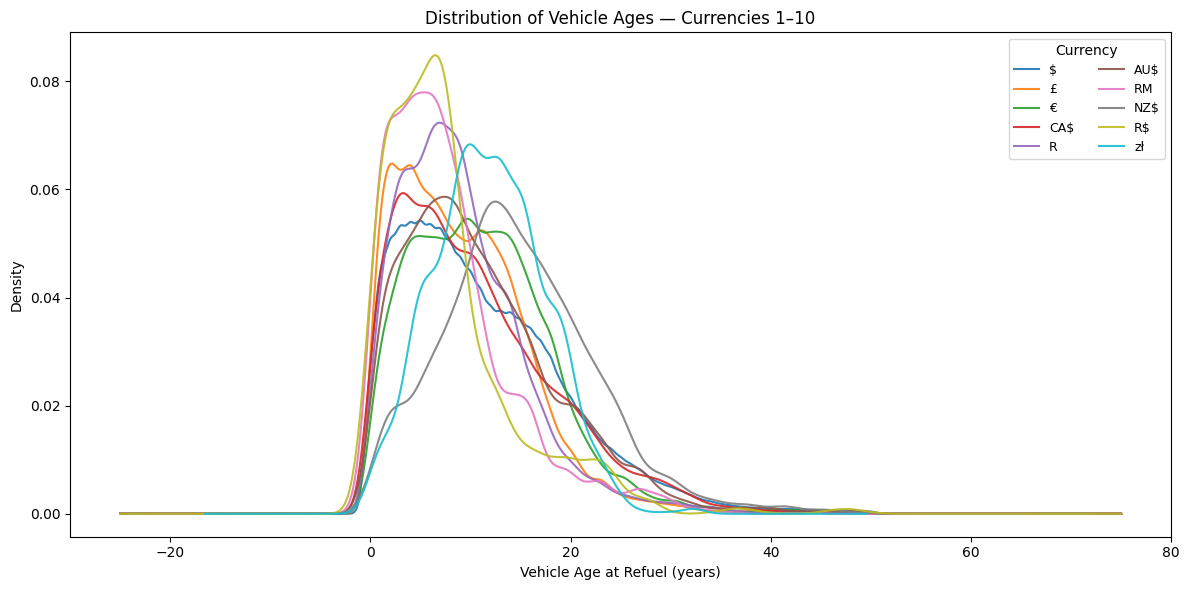

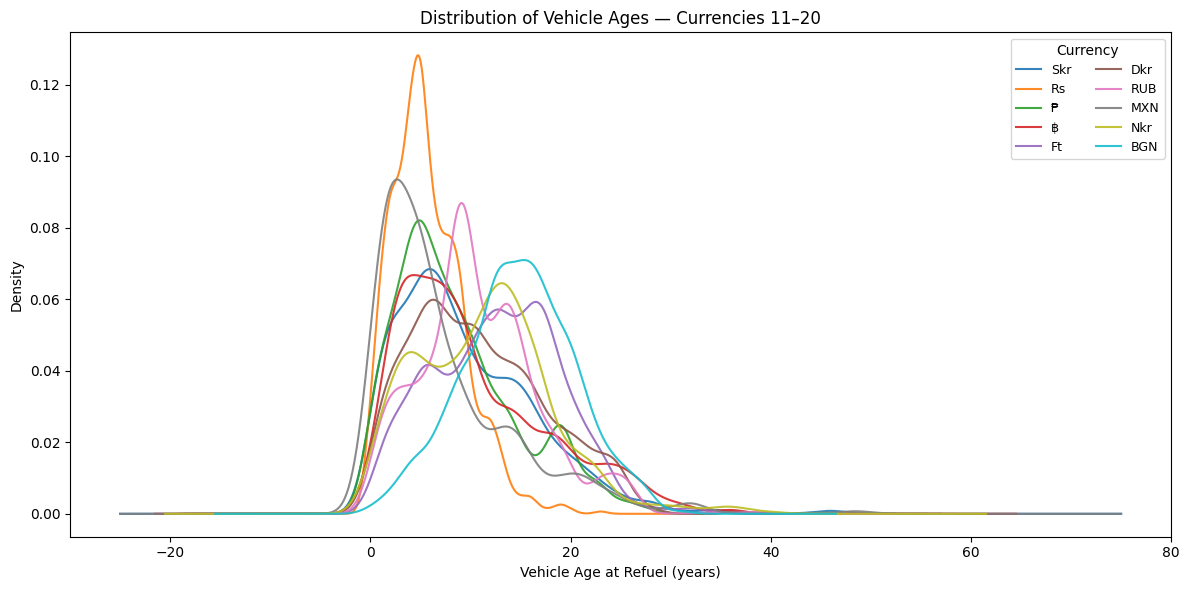

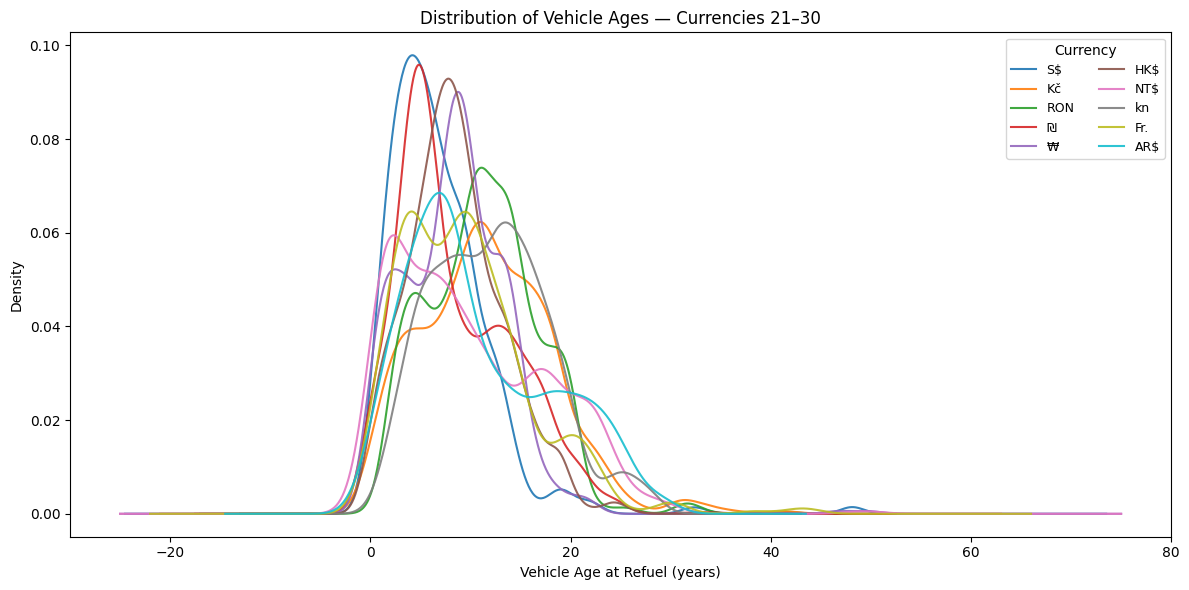

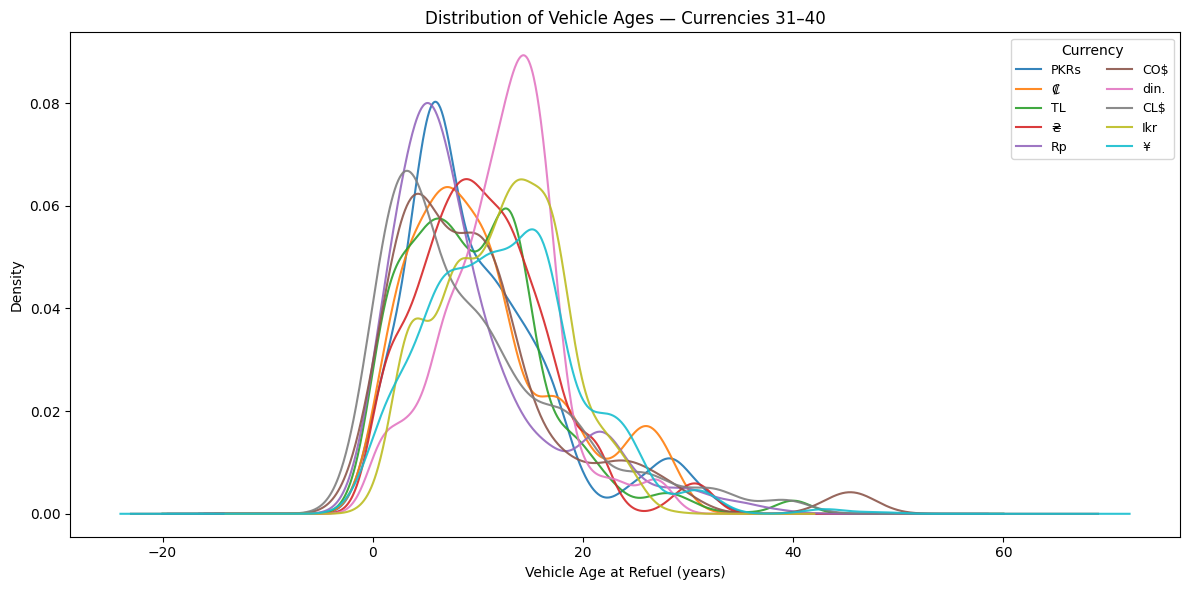

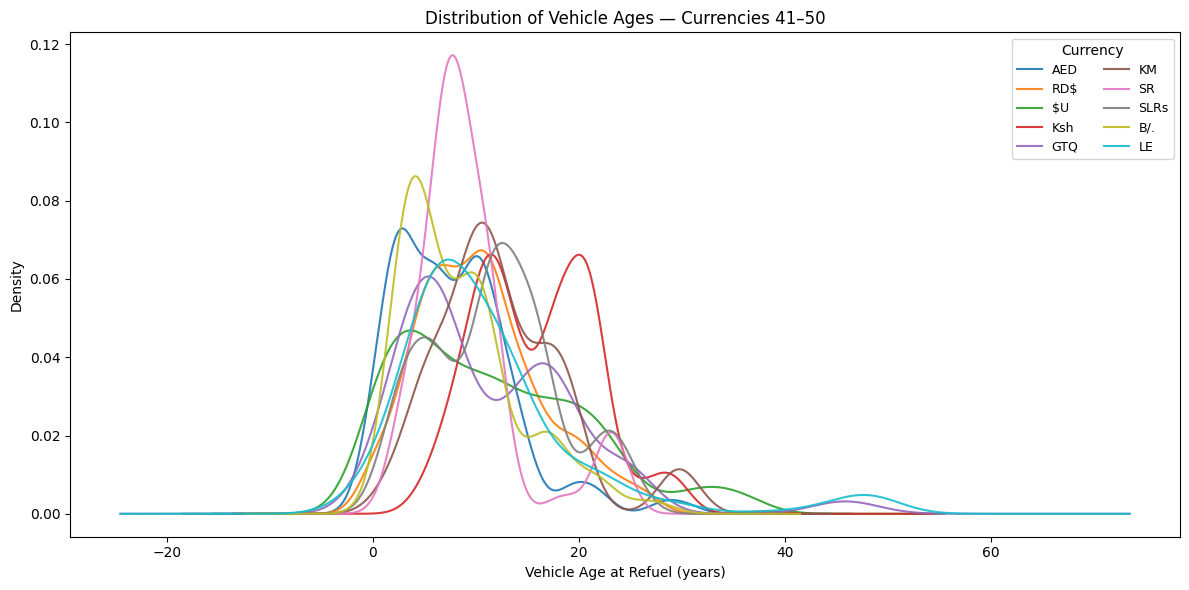

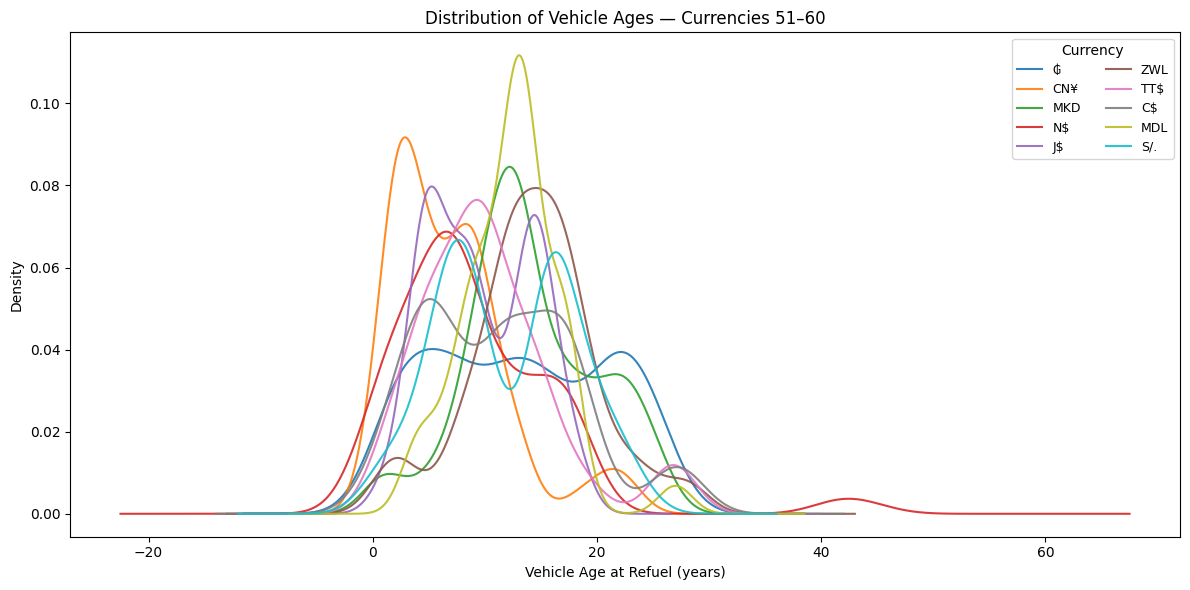

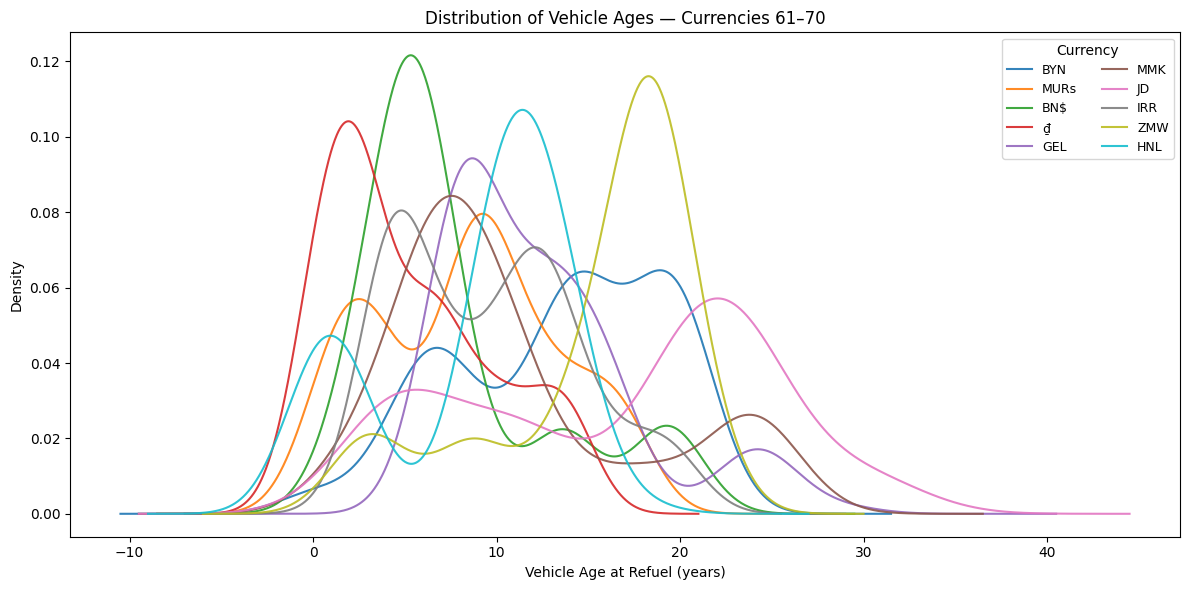

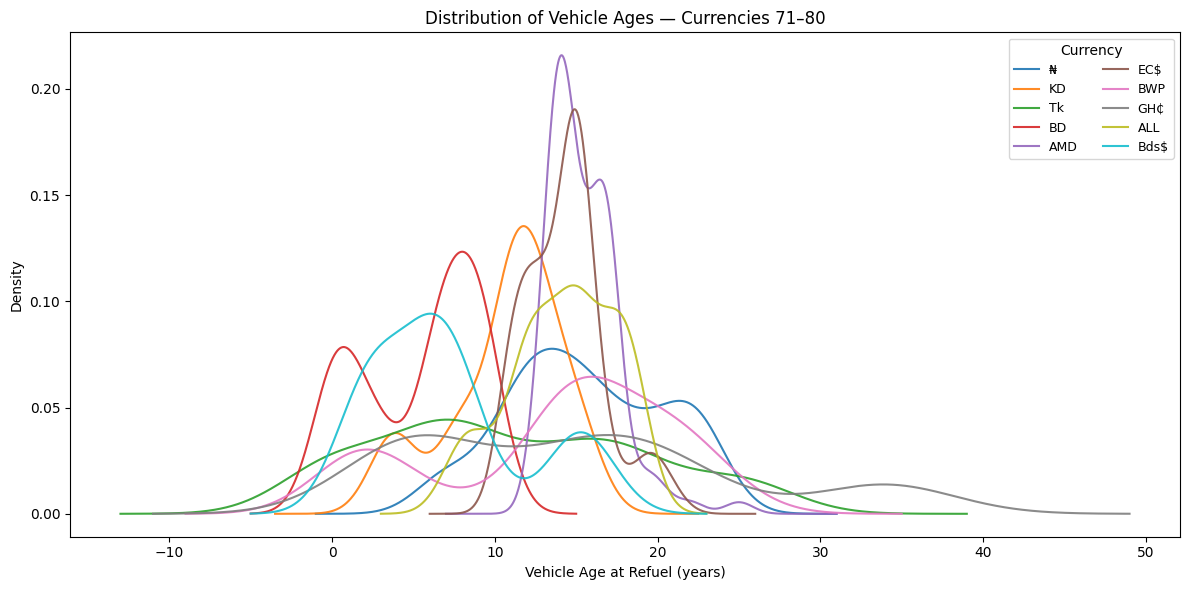

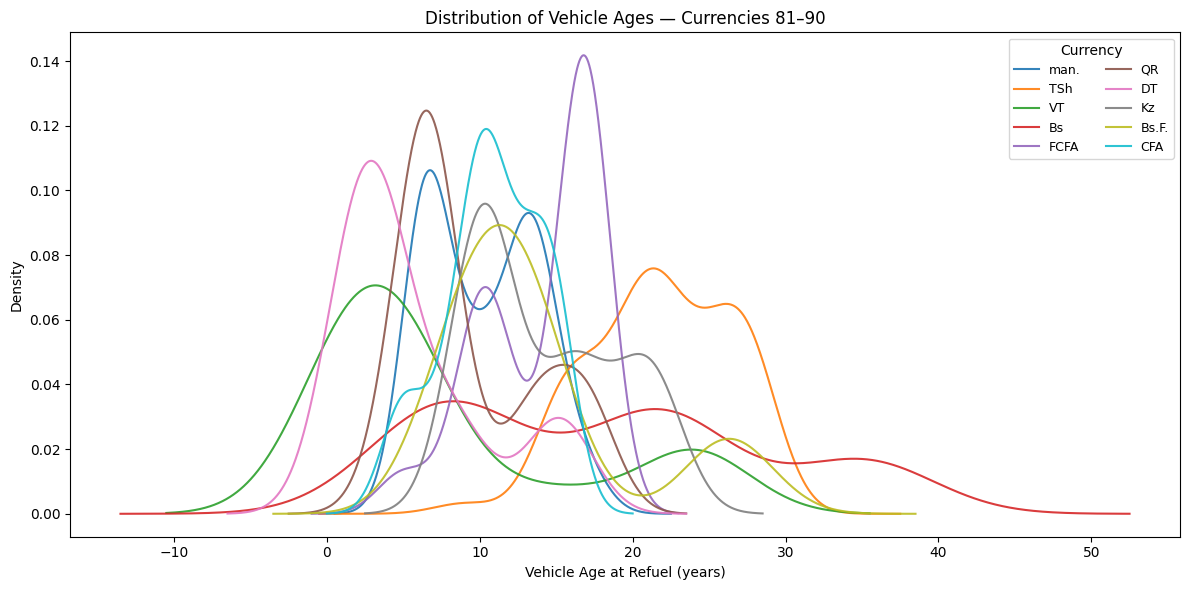

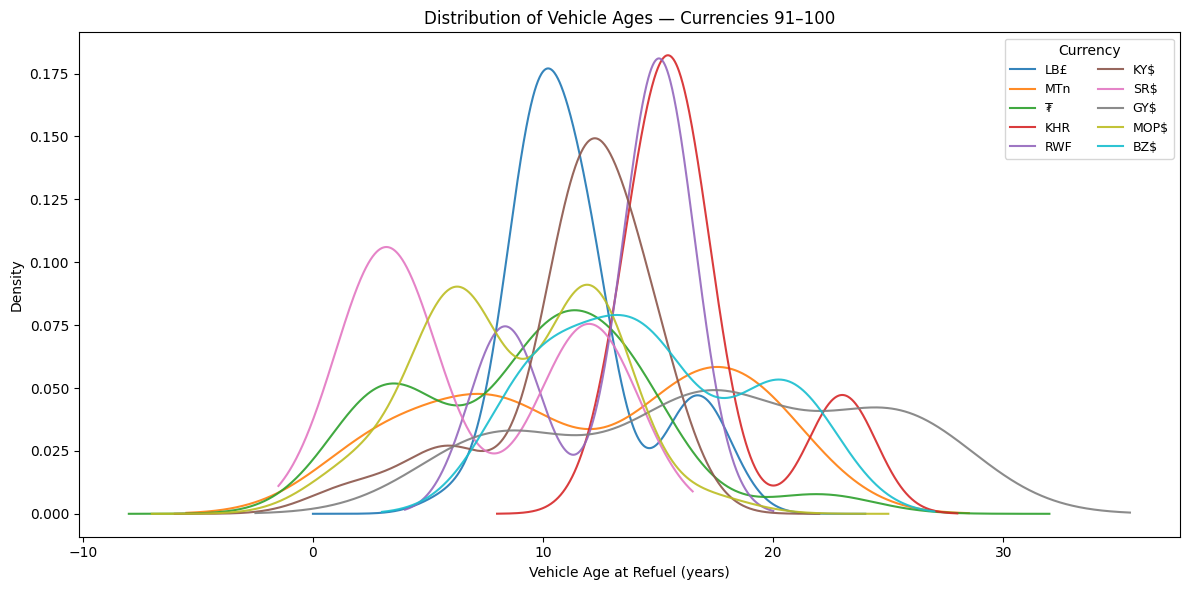

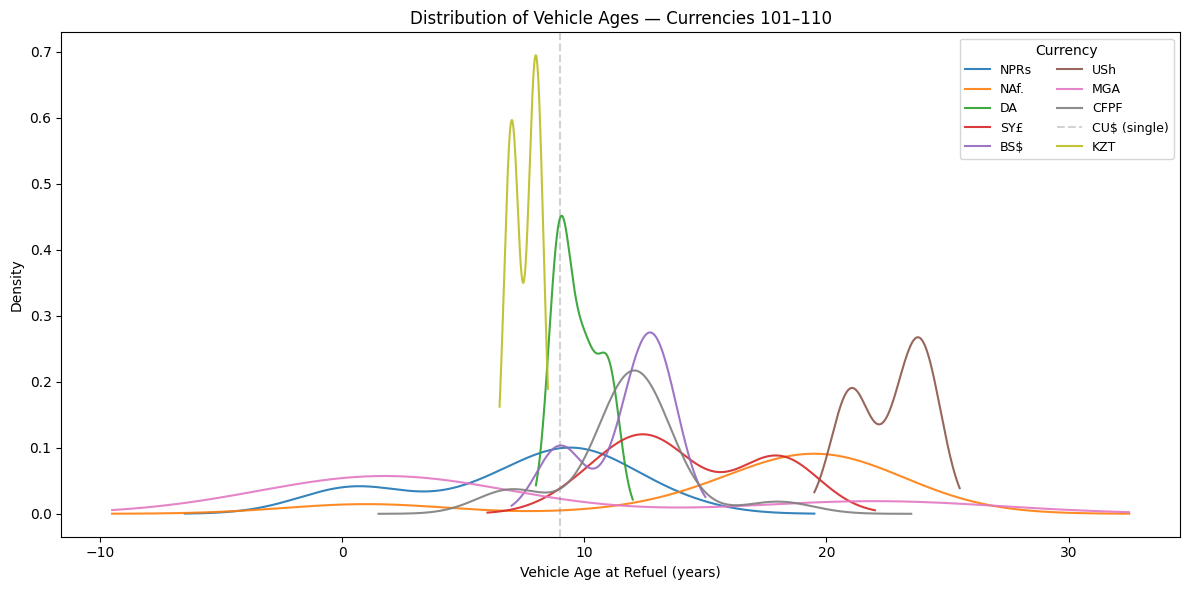

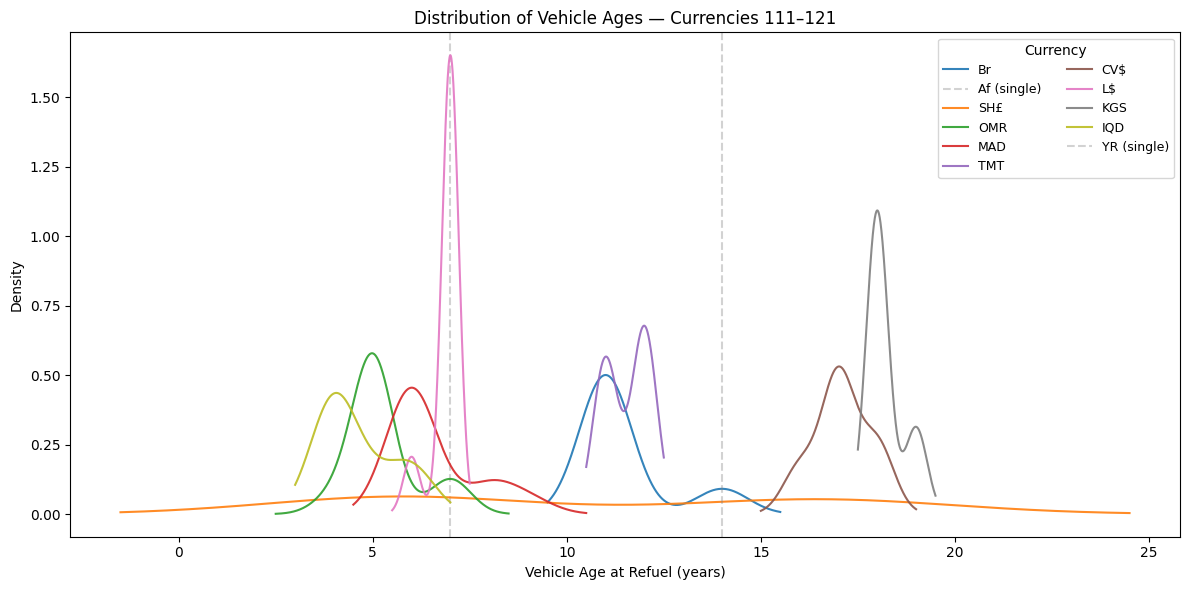

In [21]:
#3.3
df["year"] = pd.to_numeric(df["year"], errors="coerce")
if "date_fueled_dt" not in df.columns or not pd.api.types.is_datetime64_any_dtype(df["date_fueled_dt"]):
    df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

df["vehicle_age"] = df["date_fueled_dt"].dt.year - df["year"]
age_mask = (df["vehicle_age"].notna()) & (df["vehicle_age"] >= 0) & (df["vehicle_age"] <= 50)
cur_mask = df["currency"].notna()
df_age = df.loc[age_mask & cur_mask, ["currency", "vehicle_age"]].copy()

#order currencies by frequency (most to least)
currencyorder = df_age["currency"].value_counts().index.tolist()

#make exactly 12 plots: first 11 plots have 10 currencies eahc of 10, last one has 12 currencies 
groups = [currencyorder[i:i+10] for i in range(0, 110, 10)]
groups.append(currencyorder[110:])  #last plot

rng = np.random.default_rng(42) 
def plotkde(ax, values: pd.Series, label: str):
    s = values.dropna().astype(float)
    if s.empty:
        return
    if s.nunique() < 2:
        ax.axvline(float(s.iloc[0]), color="gray", alpha=0.35, linestyle="--", label=f"{label} (single)")
        return
    try:
        s.plot(kind="kde", ax=ax, label=label, alpha=0.9)
    except Exception:
        # fall back: add tiny jitter to avoid singular covariance
        sj = s + rng.normal(0, 0.05, size=s.shape)
        pd.Series(sj).plot(kind="kde", ax=ax, label=label, alpha=0.9)


for i, group in enumerate(groups, start=1):
    fig, ax = plt.subplots(figsize=(12, 6))
    for cur in group:
        vals = df_age.loc[df_age["currency"] == cur, "vehicle_age"]
        plotkde(ax, vals, cur)

    ax.set_title(f"Distribution of Vehicle Ages — Currencies {sum(len(g) for g in groups[:i-1])+1}"
                 f"–{sum(len(g) for g in groups[:i])}")
    ax.set_xlabel("Vehicle Age at Refuel (years)")
    ax.set_ylabel("Density")
    ax.legend(title="Currency", ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

All vehicle makes (by frequency):
make
ford                139023
toyota              136013
bmw                 105213
nissan               86378
volkswagen           74112
honda                65243
mercedes-benz        62200
audi                 56837
hyundai              50711
mazda                46293
lexus                40182
kia                  38723
volvo                35845
subaru               34844
jeep                 33450
mitsubishi           32756
land_rover           19672
suzuki               19100
peugeot              16737
renault              16280
fiat                 14827
citroen              12824
opel                 10396
mini                  8489
alfa_romeo            7813
isuzu                 5659
tata                   883
mahindra               508
kiaens                 293
kianival               257
truck                  192
toyotaina              144
volkswagenavelle       124
motorcycle              91
other                   47
mitsubishiisma  

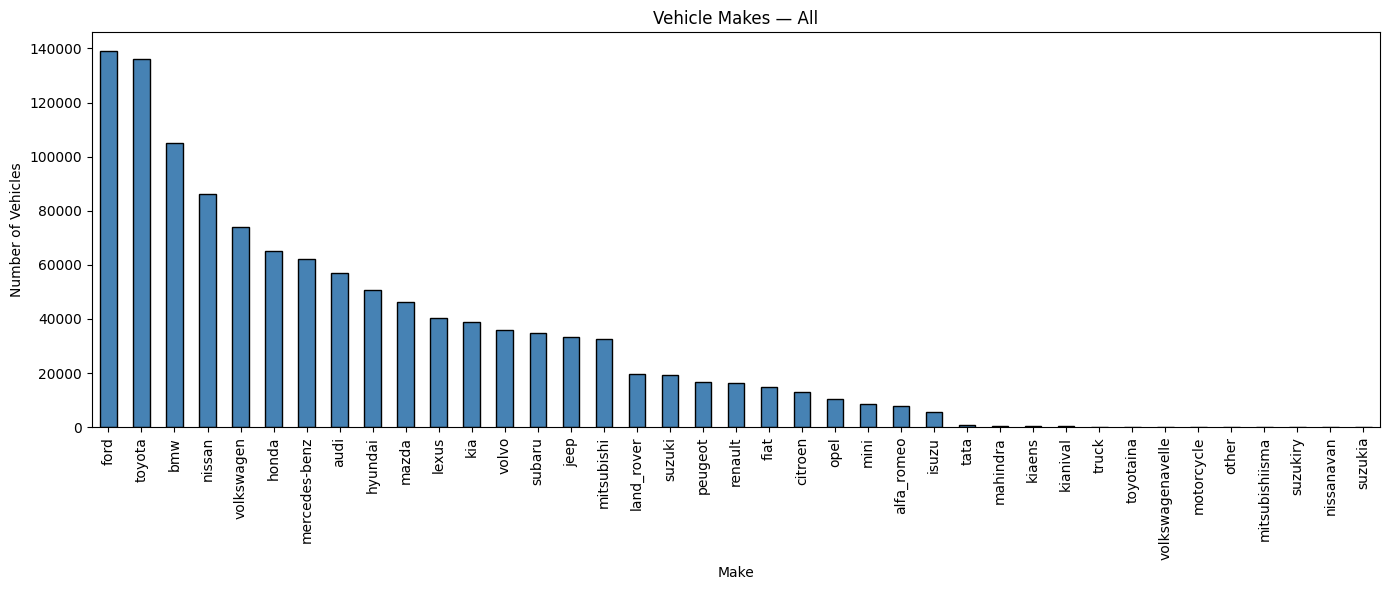


All make-model combinations:
make        model    
honda       civic        8081
toyota      4runner      7810
            corolla      7729
ford        f-150        7643
honda       accord       7625
                         ... 
nissan      patrol_dx       1
opel        monterey        1
mazda       etude           1
kianival    2022            1
alfa_romeo  gt_veloce       1
Length: 2270, dtype: int64


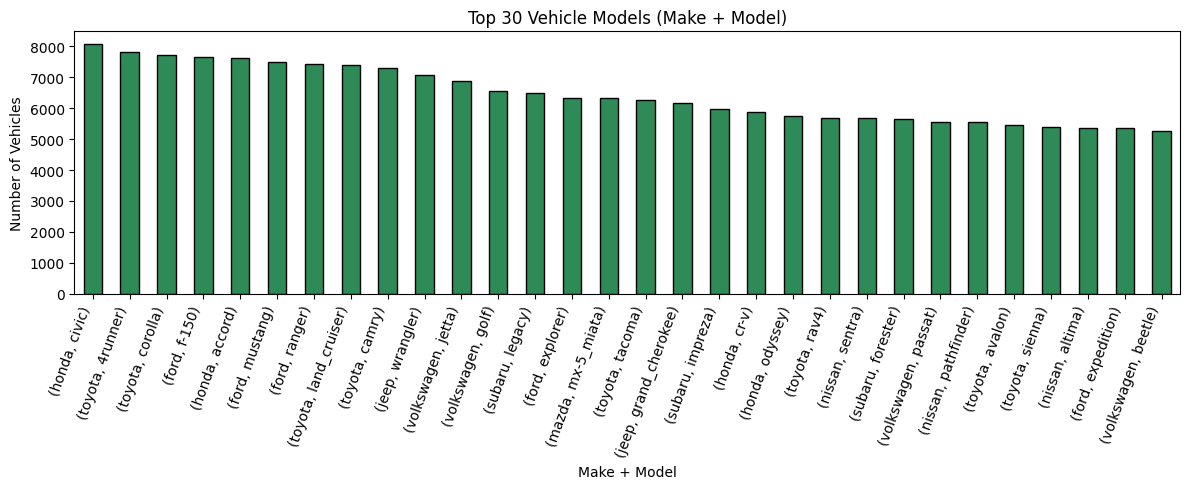

In [22]:
#3.4
#Count by make only
make_counts = df["make"].value_counts() 
print("All vehicle makes (by frequency):")
print(make_counts)
plt.figure(figsize=(14,6))   
make_counts.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Vehicle Makes — All")
plt.xlabel("Make")
plt.ylabel("Number of Vehicles")
plt.xticks(rotation=90)     
plt.tight_layout()
plt.show()

#Count by (make, model) pairs
model_counts = df.groupby(["make", "model"]).size().sort_values(ascending=False)  
print("\nAll make-model combinations:")
print(model_counts)
#Plot just the top 30 
topn = 30
plt.figure(figsize=(12,5))
model_counts.head(topn).plot(kind="bar", color="seagreen", edgecolor="black")
plt.title(f"Top {topn} Vehicle Models (Make + Model)")
plt.xlabel("Make + Model")
plt.ylabel("Number of Vehicles")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()



In [35]:
# === 4.0 — Setup for Part 4 (run once) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import re

# 0) Pick the working frame
try:
    D = df_clean.copy()
except NameError:
    D = df.copy()

# 1) Ensure datetime
if 'date_fueled_dt' in D.columns:
    D['date_fueled_dt'] = pd.to_datetime(D['date_fueled_dt'], errors='coerce')

# 2) Currency normalization (symbols -> canonical codes) and country mapping
#    Do this ONCE so all downstream cells can rely on it.
if 'currency_norm' not in D.columns:
    cur_raw = D['currency'].astype(str).str.strip()
    cur_u   = cur_raw.str.upper()
    CURRENCY_CANON = {
        'R': 'ZAR', 'ZAR': 'ZAR',
        '$': 'USD', 'US$': 'USD', 'USD': 'USD',
        '£': 'GBP', 'GBP': 'GBP',
        '€': 'EUR', 'EUR': 'EUR',
        'CA$': 'CAD', 'CAD$': 'CAD', 'CAD': 'CAD',
        # (you can extend this minimally if needed later)
    }
    D['currency_norm'] = cur_u.replace(CURRENCY_CANON)

# Country mapping should use the NORMALIZED currency
if 'country' not in D.columns:
    currency_to_country = {
        'ZAR':'South Africa',
        'USD':'United States',
        'GBP':'United Kingdom',
        'EUR':'Euro area',
        'CAD':'Canada'
    }
    D['country'] = D['currency_norm'].map(currency_to_country).fillna('Other')

# 3) Base numeric conversions (no-ops if already float)
def to_num(x): return pd.to_numeric(x, errors='coerce')
for c in ['gallons','miles','odometer','total_spent','cost_per_gallon']:
    if c in D.columns:
        D[c] = to_num(D[c])

# 4) Unit features (only fill if missing)
US_GAL_TO_L = 3.785411784
if 'liters' not in D.columns or D['liters'].isna().all():
    if 'gallons' in D.columns:
        D['liters'] = D['gallons'] * US_GAL_TO_L
if 'km' not in D.columns or D['km'].isna().all():
    if 'miles' in D.columns:
        D['km'] = D['miles'] * 1.609344
if 'L_per_100km' not in D.columns or D['L_per_100km'].isna().all():
    if {'liters','km'}.issubset(D.columns):
        D['L_per_100km'] = D['liters'] / (D['km'] / 100.0)
        D.loc[~np.isfinite(D['L_per_100km']), 'L_per_100km'] = np.nan

# 5) Simple pricing build (no cents heuristics)
if 'cpl_unit' not in D.columns:
    D['cpl_unit'] = np.nan
    if 'cost_per_gallon' in D.columns:
        D.loc[D['cost_per_gallon'].notna(), 'cpl_unit'] = D['cost_per_gallon'] / US_GAL_TO_L
if 'cpl_total' not in D.columns:
    D['cpl_total'] = np.nan
    if {'total_spent','liters'}.issubset(D.columns):
        m = D['total_spent'].notna() & D['liters'].notna() & (D['liters'] > 0)
        D.loc[m, 'cpl_total'] = D.loc[m, 'total_spent'] / D.loc[m, 'liters']
if 'cpl_local' not in D.columns:
    D['cpl_local'] = D['cpl_unit'].where(D['cpl_unit'].notna(), D['cpl_total'])

# 6) Parse make, model, model_year from user_url (once)
def extract_make_model(u: str):
    if not isinstance(u, str) or not u:
        return (np.nan, np.nan)
    parts = [p for p in urlparse(u).path.strip('/').split('/') if p]
    if len(parts) >= 2:
        mk = re.sub(r'\s+', ' ', parts[0].replace('-', ' ').replace('_',' ')).strip().lower()
        md = re.sub(r'\s+', ' ', parts[1].replace('-', ' ').replace('_',' ')).strip().lower()
        return (mk, md)
    return (np.nan, np.nan)

if not {'make','model'}.issubset(D.columns):
    mm = D['user_url'].map(extract_make_model)
    D[['make','model']] = pd.DataFrame(mm.tolist(), index=D.index)

cur_year = pd.Timestamp.today().year
if 'model_year' not in D.columns:
    year_str = D['user_url'].astype(str).str.extract(r'/((?:19|20)\d{2})(?:/|$)', expand=False)
    D['model_year'] = pd.to_numeric(year_str, errors='coerce')
    D.loc[~D['model_year'].between(1980, cur_year + 1), 'model_year'] = np.nan
if 'vehicle_age' not in D.columns:
    if 'date_fueled_dt' in D.columns:
        D['fill_year'] = D['date_fueled_dt'].dt.year
        D['vehicle_age'] = D['fill_year'] - D['model_year']
        D.loc[(D['vehicle_age'] < 0) | (D['vehicle_age'] > 50), 'vehicle_age'] = np.nan

# 7) FX for Jan 2022 (used in 4.2.1)
FX_ZAR_PER_1 = {
    'USD': 15.518617,
    'EUR': 17.575064,
    'GBP': 21.037880,
    'CAD': 12.289890,
    'ZAR': 1.0
}

print("Part 4 setup complete. Columns now available:",
      sorted(set(D.columns) & {'currency','currency_norm','country','liters','km','L_per_100km','cpl_local','make','model','model_year','vehicle_age'}))

# Use normalized currency consistently in Part 4
CURRENCY_COL = 'currency_norm' if 'currency_norm' in D.columns else 'currency'


Part 4 setup complete. Columns now available: ['L_per_100km', 'country', 'cpl_local', 'currency', 'currency_norm', 'km', 'liters', 'make', 'model', 'model_year', 'vehicle_age']


In [36]:
# === 4.1.1 — Top-5 currencies by #transactions (normalized) ===
import pandas as pd

# Guard: require currency_norm from 4.0
assert 'currency_norm' in D.columns, "Run the 4.0 setup cell to build 'currency_norm'."

# Exclude non-currencies / placeholders
exclude = {'OTHER', 'UNKNOWN', '', 'NAN', 'NONE'}

top_currencies = (
    D.loc[~D['currency_norm'].isin(exclude), 'currency_norm']
     .value_counts()
     .head(5)
)

print("Top-5 currencies by #transactions (normalized):")
display(top_currencies)

# (Optional) tiny audit so you can show mapping from raw symbols -> normalized codes in your PDF
audit = (
    D.assign(currency_raw=D['currency'].astype(str).str.strip().str.upper()))
audit = (audit
         .groupby(['currency_raw', 'currency_norm'])
         .size()
         .rename('n')
         .reset_index()
         .sort_values('n', ascending=False)
         .head(15))
print("Top raw→normalized currency mappings (for reporting/audit):")
display(audit)


Top-5 currencies by #transactions (normalized):


currency_norm
USD     738398
GBP      86147
<NA>     80656
EUR      58441
CAD      46234
Name: count, dtype: int64

Top raw→normalized currency mappings (for reporting/audit):


,currency_raw,currency_norm,n
0,$,USD,738398
109,£,GBP,86147
2,<NA>,<NA>,80656
117,€,EUR,58441
22,CA$,CAD,46234
81,R,ZAR,36034
8,AU$,AU$,23029
84,RM,RM,8549
77,NZ$,NZ$,7520
82,R$,R$,6303


In [37]:
# === 4.1.2 — Outlier removal for each of the top-5 currencies ===
# We use simple, defensible bounds; they’re intentionally broad to avoid over-pruning.

TOP5 = set(top_currencies.index.tolist())

# Plausible bands (local currency per liter):
# These are wide and meant only to remove egregious entries.
price_bounds = {
    'ZAR': (5, 40),     # R/L
    'USD': (0.30, 4.0), # $/L
    'CAD': (0.30, 4.0), # C$/L
    'GBP': (0.30, 4.0), # £/L
    'EUR': (0.30, 4.0), # €/L
}

# Physical plausibility across all currencies
phys_bounds = {
    'liters': (5, 150),         # small bike to large pickup tanks
    'gallons': (1, 40),
    'L_per_100km': (2, 25),     # ~40–1L/100km extremes filtered
}

df4 = D.copy()
keep = pd.Series(True, index=df4.index)

# Enforce physical bounds
for col, (lo, hi) in phys_bounds.items():
    if col in df4.columns:
        m = df4[col].notna()
        keep &= (~m) | (df4[col].between(lo, hi))

# Enforce price bounds per currency (only for top-5)
if 'cpl_local' in df4.columns:
    for cur, (lo, hi) in price_bounds.items():
        if cur in TOP5:
            m = (df4['currency'] == cur) & df4['cpl_local'].notna()
            keep &= (~m) | (df4['cpl_local'].between(lo, hi))

before = len(df4)
df4_clean = df4[keep].copy()
after = len(df4_clean)

print(f"Removed {before - after:,} rows as outliers "
      f"({(before - after)/max(before,1):.2%}).")
print("Remaining rows:", after)


Removed 22,851 rows as outliers (1.95%).
Remaining rows: 1149376


In [38]:
# === 4.1.3 — Removals by currency (top-5 focus, normalized) ===
assert 'currency_norm' in df4.columns, "Run 4.0 to create 'currency_norm' first."

removals = (
    df4.assign(_keep=keep)
       .groupby('currency_norm')['_keep']
       .apply(lambda s: (~s).sum())  # count removed rows per currency
       .sort_values(ascending=False)
)

print("Removed rows by currency (all, normalized):")
display(removals)

print("Removed rows among top-5 (normalized):")
display(removals.loc[removals.index.intersection(list(TOP5))])


Removed rows by currency (all, normalized):


currency_norm
USD    16678
GBP     1054
EUR      769
CAD      764
ZAR      724
       ...  
SY£        0
SR$        0
SH£        0
YR         0
₫          0
Name: _keep, Length: 122, dtype: int64

Removed rows among top-5 (normalized):


currency_norm
USD     16678
GBP      1054
EUR       769
CAD       764
<NA>      233
Name: _keep, dtype: int64

In [40]:
# === 4.2.1 — Average cost per liter by country in Jan 2022 (FX→ZAR, robust & non-redundant) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Work off your cleaned Part-4 frame
S = df4_clean.copy() if 'df4_clean' in globals() else D.copy()

# Guards: these come from 4.0
assert 'date_fueled_dt' in S.columns, "Missing 'date_fueled_dt' (run 4.0)."
assert 'currency_norm' in S.columns, "Missing 'currency_norm' (run 4.0)."
assert 'country' in S.columns, "Missing 'country' (run 4.0)."

US_GAL_TO_L = globals().get('US_GAL_TO_L', 3.785411784)
FX_ZAR_PER_1 = globals().get('FX_ZAR_PER_1', {
    'USD': 15.518617,
    'EUR': 17.575064,
    'GBP': 21.037880,
    'CAD': 12.289890,
    'ZAR': 1.0
})

# Subset to Jan 2022
J = S[(S['date_fueled_dt'].dt.year == 2022) &
      (S['date_fueled_dt'].dt.month == 1)].copy()
print(f"Jan 2022 rows (pre-price): {len(J):,}")

# Use existing local per-liter price; tiny local fallback where missing (no global mutation)
if 'cpl_local' in J.columns and J['cpl_local'].notna().any():
    J['cpl_local_used'] = J['cpl_local']
else:
    J['cpl_local_used'] = np.nan

# Fill only where still NaN and inputs exist
if 'cost_per_gallon' in J.columns:
    cpg = pd.to_numeric(J['cost_per_gallon'], errors='coerce')
    m = cpg.notna()
    J.loc[m & J['cpl_local_used'].isna(), 'cpl_local_used'] = cpg[m] / US_GAL_TO_L

if {'total_spent','liters'}.issubset(J.columns):
    ts  = pd.to_numeric(J['total_spent'], errors='coerce')
    lit = pd.to_numeric(J['liters'], errors='coerce')
    m2  = ts.notna() & lit.notna() & (lit > 0) & J['cpl_local_used'].isna()
    J.loc[m2, 'cpl_local_used'] = (ts[m2] / lit[m2]).values

# Convert to ZAR using NORMALIZED currency
J['cpl_ZAR'] = J.apply(
    lambda r: r['cpl_local_used'] * FX_ZAR_PER_1.get(r['currency_norm'], np.nan)
              if np.isfinite(r['cpl_local_used']) else np.nan,
    axis=1
)

# Aggregate
cpl_by_country = (J.dropna(subset=['cpl_ZAR','country'])
                    .groupby('country')['cpl_ZAR']
                    .mean()
                    .sort_values(ascending=False))

print("Average cost per liter in ZAR (Jan 2022):")
display(cpl_by_country)

# Only plot when we actually have data
if cpl_by_country.empty:
    print("No valid Jan-2022 country averages to plot. Coverage diagnostics:")
    diag = (
        J.assign(has_price=J['cpl_local_used'].notna(),
                 has_fx=J['currency_norm'].map(FX_ZAR_PER_1).notna())
         .groupby('currency_norm')[['has_price','has_fx']]
         .sum()
         .sort_values('has_price', ascending=False)
    )
    display(diag.head(15))
else:
    plt.figure(figsize=(8,4))
    cpl_by_country.plot(kind='bar', edgecolor='black')
    plt.ylabel("Average cost per liter (ZAR) — Jan 2022")
    plt.title("Cost per liter by country (Jan 2022, FX→ZAR)")
    plt.tight_layout()
    plt.show()


Jan 2022 rows (pre-price): 49,166
Average cost per liter in ZAR (Jan 2022):


Series([], Name: cpl_ZAR, dtype: float64)

No valid Jan-2022 country averages to plot. Coverage diagnostics:


,has_price,has_fx
currency_norm,,
$U,0,0
<NA>,0,0
AED,0,0
AMD,0,0
AR$,0,0
AU$,0,0
B/.,0,0
BD,0,0
BDS$,0,0


Estimated missed fill-up candidates: 37847 / 980635 intervals (3.86%).


,user_url,prev_date,date_fueled_dt,delta_days,prev_odometer,odometer,delta_miles,gallons,interval_mpg,thr_mpg,excess_ratio
714804,https://www.somewebsite.com/jeep/grand_cheroke...,2018-01-25,2018-02-07,13.0,110656.0,7110961.0,7000305.0,3.563,1.964722e+06,181.867880,10803.018902
1049655,https://www.somewebsite.com/isuzu/d-max/2005/6...,2017-08-29,2018-01-21,145.0,219300.0,360395.0,141095.0,4.153,3.397424e+04,3.311484,10259.519218
957634,https://www.somewebsite.com/volvo/245/1991/73141,2011-05-09,2011-05-21,12.0,222272.0,2222780.0,2000508.0,2.300,8.697861e+05,108.800913,7994.290306
1135098,https://www.somewebsite.com/mercedes-benz/e420...,2016-08-25,2017-06-09,288.0,31430.0,327829.0,296399.0,3.139,9.442466e+04,23.331334,4047.117888
574521,https://www.somewebsite.com/ford/falcon/1968/3...,2015-02-09,2018-05-17,1193.0,75010.0,784273.0,709263.0,10.165,6.977501e+04,24.298663,2871.557704
345811,https://www.somewebsite.com/toyota/mr2/1985/18...,2013-09-08,2013-09-17,9.0,179926.0,9180140.0,9000214.0,6.440,1.397549e+06,664.178458,2104.176583
913280,https://www.somewebsite.com/ford/ranger/1987/4...,2014-05-27,2014-06-18,22.0,149188.0,1495508.0,1346320.0,10.667,1.262136e+05,72.592285,1738.663492
461946,https://www.somewebsite.com/nissan/sentra/1998...,2012-10-03,2013-01-23,112.0,107338.0,1090991.0,983653.0,5.867,1.676586e+05,97.801235,1714.278953
350497,https://www.somewebsite.com/volvo/v40/2000/223687,2013-09-21,2013-10-17,26.0,240235.0,2451516.0,2211281.0,10.068,2.196346e+05,139.330514,1576.356669
889846,https://www.somewebsite.com/ford/e-150_econoli...,2018-07-12,2018-07-21,9.0,203298.0,2203870.0,2000572.0,12.743,1.569938e+05,112.396174,1396.789545


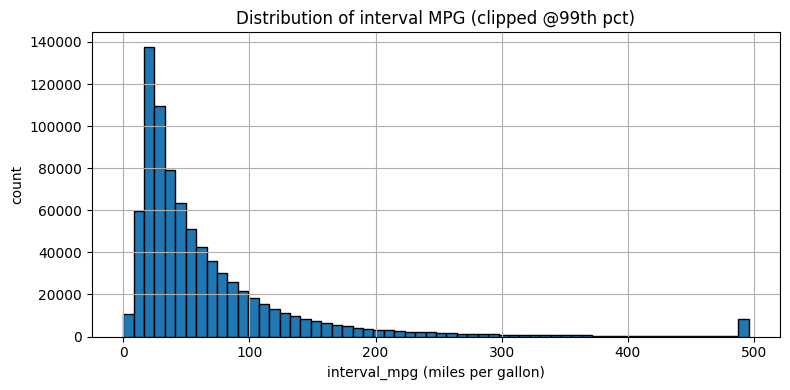

In [29]:
# === 4.2.2 — Missed fill-ups based on interval MPG & distance (on cleaned df) ===
dfm = df4_clean.copy()
for c in ['odometer','gallons']:
    if c in dfm.columns: dfm[c] = pd.to_numeric(dfm[c], errors='coerce')

# Build per-user intervals
work_idx = dfm.dropna(subset=['date_fueled_dt','odometer']).index
work = dfm.loc[work_idx, ['user_url','date_fueled_dt','odometer','gallons']].sort_values(
    ['user_url','date_fueled_dt']
).copy()
work['prev_odometer'] = work.groupby('user_url')['odometer'].shift(1)
work['prev_date']     = work.groupby('user_url')['date_fueled_dt'].shift(1)
work['delta_miles']   = work['odometer'] - work['prev_odometer']
work['delta_days']    = (work['date_fueled_dt'] - work['prev_date']).dt.days
valid = (work['gallons'] > 0) & np.isfinite(work['gallons']) & (work['delta_miles'] > 0)
work['interval_mpg']  = np.where(valid, work['delta_miles'] / work['gallons'], np.nan)
work['odo_nonmono']   = work['delta_miles'] < 0

# Per-user robust thresholds
def iqr_upper(s):
    s = s.dropna()
    if s.empty: return np.nan
    q1, q3 = np.percentile(s, [25, 75])
    return q3 + 1.5*(q3 - q1)

grp = work.groupby('user_url', group_keys=False)
thr_mpg   = grp['interval_mpg'].apply(iqr_upper).rename('thr_mpg')
thr_miles = grp['delta_miles'].apply(iqr_upper).rename('thr_miles')
work = work.merge(thr_mpg, left_on='user_url', right_index=True, how='left')
work = work.merge(thr_miles, left_on='user_url', right_index=True, how='left')

# Flag candidates
mask = (
    (~work['odo_nonmono']) &
    np.isfinite(work['interval_mpg']) &
    np.isfinite(work['thr_mpg']) & np.isfinite(work['thr_miles']) &
    (work['interval_mpg'] > work['thr_mpg']) &
    (work['delta_miles']  > work['thr_miles'])
)
work['missed_fill_candidate'] = mask

n_cand = int(mask.sum())
n_valid = int((~work['odo_nonmono']).sum())
print(f"Estimated missed fill-up candidates: {n_cand} / {n_valid} intervals ({n_cand/max(n_valid,1):.2%}).")

# Show examples
ex = (work[work['missed_fill_candidate']]
      .assign(excess_ratio = work['interval_mpg'] / work['thr_mpg'])
      .sort_values('excess_ratio', ascending=False)
      .loc[:, ['user_url','prev_date','date_fueled_dt','delta_days',
               'prev_odometer','odometer','delta_miles','gallons',
               'interval_mpg','thr_mpg','excess_ratio']]
      .head(20))
display(ex)

# quick visual
vals = work.loc[(~work['odo_nonmono']) & np.isfinite(work['interval_mpg']), 'interval_mpg']
if not vals.empty:
    plt.figure(figsize=(8,4))
    vals.clip(upper=np.nanpercentile(vals, 99)).hist(bins=60, edgecolor='black')
    plt.title("Distribution of interval MPG (clipped @99th pct)")
    plt.xlabel("interval_mpg (miles per gallon)")
    plt.ylabel("count")
    plt.tight_layout(); plt.show()


Rule: For each user, compute the MPG for each interval (interval_mpg = Δodometer / gallons) and the interval distance (Δodometer) from their time-ordered logs. Flag an interval as a missed fill-up if (i) odometer is non-decreasing, (ii) interval_mpg is above the user’s robust upper bound (Q3 + 1.5×IQR), and (iii) the interval distance is also above the user’s robust upper bound. This catches long gaps where fuel was likely added but not logged, which otherwise inflate the computed per-fill MPG.

Average distance per tank (km), by country:


,avg_km_per_tank,n_tanks,median_km
country,,,
Euro area,594.769667,47214,575.588641
United Kingdom,578.341375,76283,553.131533
South Africa,539.830636,29510,523.364623
Other,484.569268,108715,456.409958
United States,461.877486,635685,446.967937
Canada,443.699605,41223,428.574906


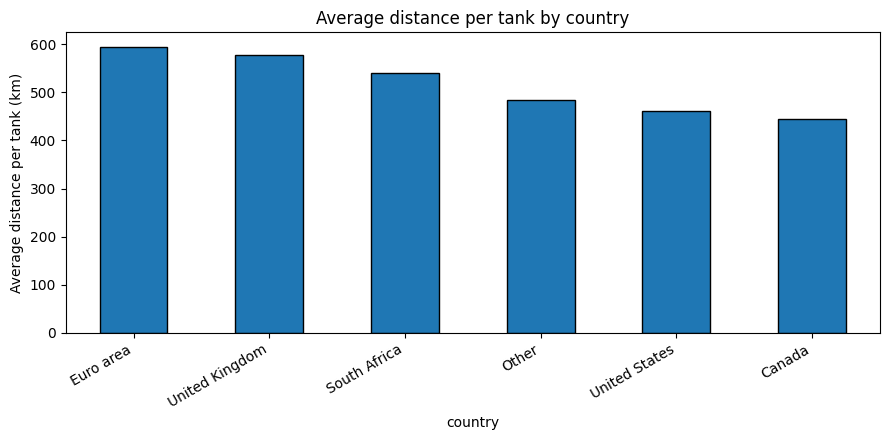

Largest average distance per tank: Euro area — 594.8 km


In [41]:
# === 4.2.3 — Average distance per tank (km) by country ===
km_by_country = (df4_clean
                 .dropna(subset=['km','country'])
                 .groupby('country')
                 .agg(avg_km_per_tank=('km','mean'),
                      n_tanks=('km','size'),
                      median_km=('km','median'))
                 .sort_values('avg_km_per_tank', ascending=False))
print("Average distance per tank (km), by country:")
display(km_by_country)

plt.figure(figsize=(9,4.5))
km_by_country['avg_km_per_tank'].plot(kind='bar', edgecolor='black')
plt.ylabel("Average distance per tank (km)")
plt.title("Average distance per tank by country")
plt.xticks(rotation=30, ha='right')
plt.tight_layout(); plt.show()

if not km_by_country.empty:
    print(f"Largest average distance per tank: {km_by_country.index[0]} — {km_by_country.iloc[0]['avg_km_per_tank']:.1f} km")


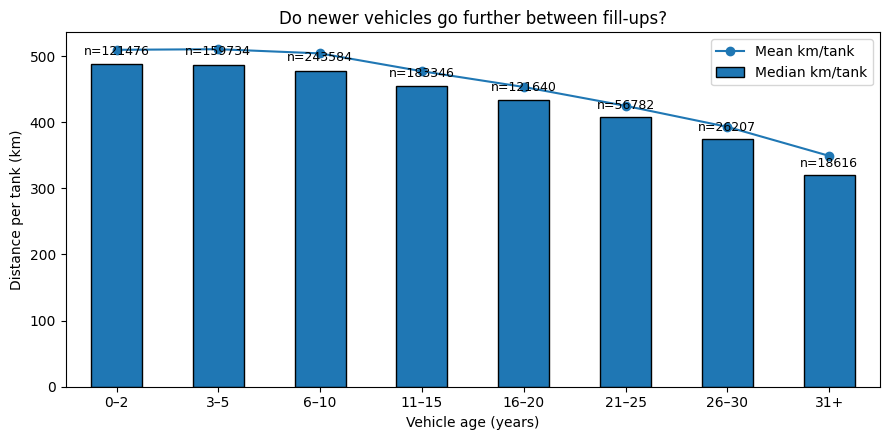

Rank correlation (vehicle_age vs km): rho ≈ -0.180 (negative ⇒ newer vehicles go further)


In [42]:
# === 4.2.4 — Distance per tank vs vehicle age ===
use = df4_clean.dropna(subset=['vehicle_age','km']).copy()
use['vehicle_age'] = use['vehicle_age'].astype(float)

bins   = [-0.5, 2.5, 5.5, 10.5, 15.5, 20.5, 25.5, 30.5, 50.5]
labels = ['0–2','3–5','6–10','11–15','16–20','21–25','26–30','31+']
use['age_bin'] = pd.cut(use['vehicle_age'], bins=bins, labels=labels, include_lowest=True)

by_age = (use.groupby('age_bin', observed=True)
          .agg(avg_km=('km','mean'),
               med_km=('km','median'),
               n=('km','size'))
          .dropna())

plt.figure(figsize=(9,4.5))
ax = by_age['med_km'].plot(kind='bar', edgecolor='black', label='Median km/tank')
by_age['avg_km'].plot(marker='o', linestyle='-', ax=ax, label='Mean km/tank')
for i, (idx, row) in enumerate(by_age.iterrows()):
    ax.text(i, row['med_km']*1.02, f"n={int(row['n'])}", ha='center', va='bottom', fontsize=9)
plt.ylabel("Distance per tank (km)")
plt.xlabel("Vehicle age (years)")
plt.title("Do newer vehicles go further between fill-ups?")
plt.legend(); plt.tight_layout(); plt.show()

# Spearman-like rank correlation
rho = use['vehicle_age'].rank().corr(use['km'].rank())
print(f"Rank correlation (vehicle_age vs km): rho ≈ {rho:.3f} (negative ⇒ newer vehicles go further)")


SA rows before efficiency filtering: 35,310
Rows after efficiency sanity window (2–25 L/100km): 29,509
Top-5 most-logged SA vehicles and their L/100km:


,n_logs,median_L100,mean_L100,p25_L100,p75_L100
vehicle,,,,,
toyota hilux,1173,11.308393,11.909429,10.051905,13.067477
mitsubishi pajero,966,12.250760,12.841558,10.771618,14.793370
toyota fortuner,901,10.940213,11.298859,9.800608,12.511414
suzuki jimny,852,8.876022,9.214859,8.085189,10.051905
volkswagen amarok,663,10.500651,10.692364,9.445613,11.682325


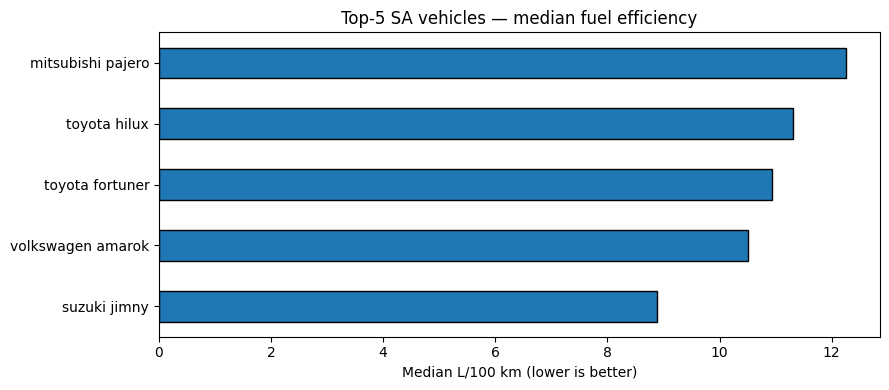

In [45]:
# === 4.2.5 — Top-5 SA vehicles (by #logs) and their fuel efficiency ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import re

# 0) Working frame
S = df4_clean.copy() if 'df4_clean' in globals() else (D.copy() if 'D' in globals() else df.copy())

# 1) Filter to South Africa using the country column created in 4.0
assert 'country' in S.columns, "Run your 4.0 setup to build 'country' first."
SA = S[S['country'] == 'South Africa'].copy()
print(f"SA rows before efficiency filtering: {len(SA):,}")

if SA.empty:
    print("No South African rows available. Cannot compute 4.2.5.")
else:
    # 2) Ensure L/100km exists (compute only if missing)
    if 'L_per_100km' not in SA.columns or SA['L_per_100km'].isna().all():
        # Use existing liters & km if present; fall back to gallons/miles only if needed
        if 'liters' not in SA.columns and 'gallons' in SA.columns:
            US_GAL_TO_L = globals().get('US_GAL_TO_L', 3.785411784)
            SA['liters'] = pd.to_numeric(SA['gallons'], errors='coerce') * US_GAL_TO_L
        if 'km' not in SA.columns and 'miles' in SA.columns:
            SA['km'] = pd.to_numeric(SA['miles'], errors='coerce') * 1.609344
        if {'liters','km'}.issubset(SA.columns):
            SA['L_per_100km'] = pd.to_numeric(SA['liters'], errors='coerce') / (
                                    pd.to_numeric(SA['km'], errors='coerce') / 100.0
                                )
            SA.loc[~np.isfinite(SA['L_per_100km']), 'L_per_100km'] = np.nan

    # 3) Build vehicle label (prefer make/model; else extract from user_url locally)
    if {'make','model'}.issubset(SA.columns):
        SA['vehicle'] = (SA['make'].fillna('') + ' ' + SA['model'].fillna('')).str.strip()
    else:
        def extract_make_model(u: str):
            if not isinstance(u, str) or not u:
                return (np.nan, np.nan)
            parts = [p for p in urlparse(u).path.strip('/').split('/') if p]
            if len(parts) >= 2:
                mk = re.sub(r'\s+', ' ', parts[0].replace('-', ' ').replace('_',' ')).strip().lower()
                md = re.sub(r'\s+', ' ', parts[1].replace('-', ' ').replace('_',' ')).strip().lower()
                return (mk, md)
            return (np.nan, np.nan)
        mm_local = SA['user_url'].map(extract_make_model)
        SA[['make_local','model_local']] = pd.DataFrame(mm_local.tolist(), index=SA.index)
        SA['vehicle'] = (SA['make_local'].fillna('') + ' ' + SA['model_local'].fillna('')).str.strip()

    SA.loc[SA['vehicle'] == '', 'vehicle'] = np.nan

    # 4) Efficiency sanity window to avoid partial fills / unit problems
    SA_eff = SA.dropna(subset=['vehicle', 'L_per_100km']).copy()
    SA_eff = SA_eff[(SA_eff['L_per_100km'] >= 2.0) & (SA_eff['L_per_100km'] <= 25.0)]
    print(f"Rows after efficiency sanity window (2–25 L/100km): {len(SA_eff):,}")

    if SA_eff.empty:
        print("No SA rows remain after filtering; cannot compute top-5 vehicles.")
    else:
        # 5) Top-5 vehicles by #logs
        vc = SA_eff.groupby('vehicle', dropna=True)['L_per_100km'].size().sort_values(ascending=False)
        top5_names = vc.head(5).index.tolist()

        if not top5_names:
            print("No enough vehicle labels to form a top-5.")
        else:
            top5 = (SA_eff[SA_eff['vehicle'].isin(top5_names)]
                    .groupby('vehicle', as_index=True)['L_per_100km']
                    .agg(n_logs='size',
                         median_L100='median',
                         mean_L100='mean',
                         p25_L100=lambda s: np.percentile(s, 25),
                         p75_L100=lambda s: np.percentile(s, 75))
                    .sort_values('n_logs', ascending=False))

            print("Top-5 most-logged SA vehicles and their L/100km:")
            display(top5)

            # 6) Plot only if non-empty
            ser = top5.sort_values('median_L100')['median_L100']
            if ser.empty:
                print("Nothing to plot (no median values).")
            else:
                plt.figure(figsize=(9,4))
                ser.plot(kind='barh', edgecolor='black')
                plt.xlabel("Median L/100 km (lower is better)")
                plt.ylabel("")
                plt.title("Top-5 SA vehicles — median fuel efficiency")
                plt.tight_layout()
                plt.show()


In [49]:
# === 4.2.6 — Most fuel-efficient vehicles in each country (median L/100km) ===
X = df4_clean.copy()
if 'L_per_100km' not in X.columns:
    X['L_per_100km'] = X['liters'] / (X['km']/100.0)
X['vehicle'] = (X['make'].fillna('') + ' ' + X['model'].fillna('')).str.strip()
X.loc[X['vehicle']=='','vehicle'] = np.nan

# Filter to reasonable efficiencies and require minimum samples per vehicle
min_n = 50  # tweak if needed
Xe = (X.dropna(subset=['country','vehicle','L_per_100km'])
        .loc[(X['L_per_100km']>=2) & (X['L_per_100km']<=25)])
g = (Xe.groupby(['country','vehicle'])['L_per_100km']
       .agg(['median','count']).rename(columns={'median':'median_L100','count':'n'})
       .reset_index())
g = g[g['n'] >= min_n]

# Pick the most efficient (lowest median) per country
winners = g.sort_values(['country','median_L100']).groupby('country').head(1).reset_index(drop=True)
print("Most fuel-efficient vehicles by country (median L/100km; n ≥ {min_n}):")
display(winners)


Most fuel-efficient vehicles by country (median L/100km; n ≥ {min_n}):


,country,vehicle,median_L100,n
0,Canada,toyota prius_prime,3.591062,57
1,Euro area,hyundai ioniq,4.839827,50
2,Other,volkswagen lupo,3.980125,52
3,South Africa,toyota aygo,5.647417,58
4,United Kingdom,hyundai ioniq,4.400651,116
5,United States,toyota prius_prime,3.558466,641


Canadian rows before efficiency filtering: 45,470
Rows after efficiency sanity window (2–25 L/100km): 41,221
Top-5 Canadian vehicles — seasonal median L/100km (with counts):


/tmp/ipykernel_1441/1833472351.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_vm = (C5.groupby(['vehicle', 'season'])['L_per_100km']


,vehicle,season,median_L100,n
0,hyundai accent,Winter,8.592533,135
1,hyundai accent,Spring,7.866708,134
2,hyundai accent,Summer,7.209992,83
3,hyundai accent,Autumn,7.699352,126
4,mazda 3_sport,Winter,8.267673,210
5,mazda 3_sport,Spring,8.082975,163
6,mazda 3_sport,Summer,7.661713,155
7,mazda 3_sport,Autumn,7.762838,212
8,toyota matrix,Winter,8.878981,153
9,toyota matrix,Spring,8.990103,103


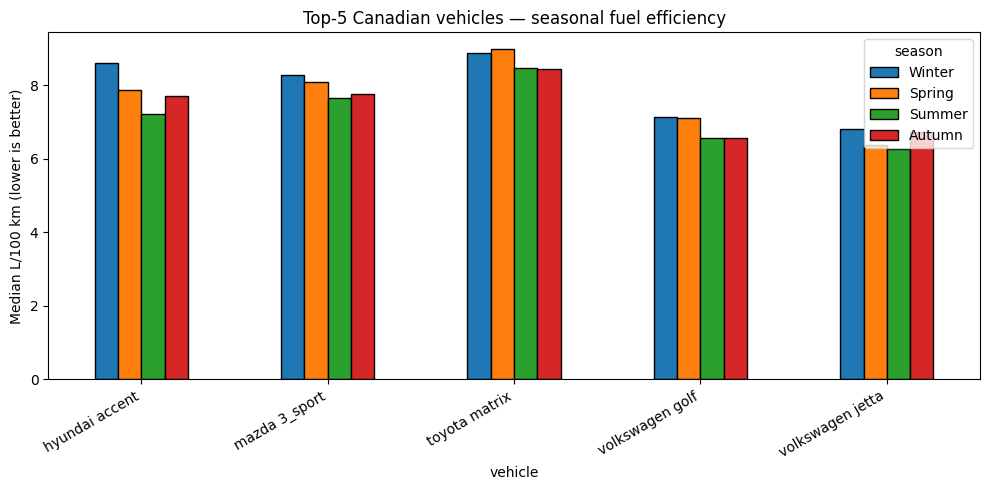

In [51]:
# === 4.2.7 — Top-5 Canadian vehicles: seasonal efficiency differences  ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import re

# 0) Working frame (already cleaned in Part 4)
S = df4_clean.copy() if 'df4_clean' in globals() else (D.copy() if 'D' in globals() else df.copy())

# 1) Subset to Canada using multiple fallbacks (country, currency_norm, raw currency)
conds = []
if 'country' in S.columns:
    conds.append(S['country'] == 'Canada')
if 'currency_norm' in S.columns:
    conds.append(S['currency_norm'] == 'CAD')
if 'currency' in S.columns:
    conds.append(S['currency'].isin(['CAD', 'CA$']))

if conds:
    CA = S[np.logical_or.reduce(conds)].copy()
else:
    CA = pd.DataFrame(columns=S.columns)

print(f"Canadian rows before efficiency filtering: {len(CA):,}")
if CA.empty:
    print("No Canadian rows found. Check your 4.0 setup for 'currency_norm' and 'country'.")
else:
    # 2) Ensure L/100km exists (compute only if missing/NaN)
    if 'L_per_100km' not in CA.columns or CA['L_per_100km'].isna().all():
        # Only fill the pieces we need locally if missing
        if 'liters' not in CA.columns and 'gallons' in CA.columns:
            US_GAL_TO_L = globals().get('US_GAL_TO_L', 3.785411784)
            CA['liters'] = pd.to_numeric(CA['gallons'], errors='coerce') * US_GAL_TO_L
        if 'km' not in CA.columns and 'miles' in CA.columns:
            CA['km'] = pd.to_numeric(CA['miles'], errors='coerce') * 1.609344
        if {'liters','km'}.issubset(CA.columns):
            CA['L_per_100km'] = pd.to_numeric(CA['liters'], errors='coerce') / (
                                    pd.to_numeric(CA['km'], errors='coerce') / 100.0
                                )
            CA.loc[~np.isfinite(CA['L_per_100km']), 'L_per_100km'] = np.nan

    # 3) Vehicle label (prefer existing make/model; else parse from user_url locally)
    if {'make','model'}.issubset(CA.columns):
        CA['vehicle'] = (CA['make'].fillna('') + ' ' + CA['model'].fillna('')).str.strip()
    else:
        def extract_make_model(u: str):
            if not isinstance(u, str) or not u:
                return (np.nan, np.nan)
            parts = [p for p in urlparse(u).path.strip('/').split('/') if p]
            if len(parts) >= 2:
                mk = re.sub(r'\s+', ' ', parts[0].replace('-', ' ').replace('_',' ')).strip().lower()
                md = re.sub(r'\s+', ' ', parts[1].replace('-', ' ').replace('_',' ')).strip().lower()
                return (mk, md)
            return (np.nan, np.nan)
        mm = CA['user_url'].map(extract_make_model)
        CA[['make_local','model_local']] = pd.DataFrame(mm.tolist(), index=CA.index)
        CA['vehicle'] = (CA['make_local'].fillna('') + ' ' + CA['model_local'].fillna('')).str.strip()

    CA.loc[CA['vehicle'] == '', 'vehicle'] = np.nan

    # 4) Keep reasonable efficiencies to avoid partial fills / units
    CA = CA.dropna(subset=['vehicle', 'L_per_100km', 'date_fueled_dt'])
    CA = CA[(CA['L_per_100km'] >= 2) & (CA['L_per_100km'] <= 25)]
    print(f"Rows after efficiency sanity window (2–25 L/100km): {len(CA):,}")

    if CA.empty:
        print("Canadian subset has no rows after sanity filtering (2–25 L/100km & non-null vehicle/date).")
    else:
        # 5) Top-5 vehicles by number of logs
        top5_ca = (CA.groupby('vehicle').size()
                     .sort_values(ascending=False)
                     .head(5).index.tolist())
        C5 = CA[CA['vehicle'].isin(top5_ca)].copy()

        if C5.empty:
            print("Top-5 Canadian vehicles set is empty after filtering; nothing to plot.")
        else:
            # 6) Assign seasons
            month = C5['date_fueled_dt'].dt.month
            season = pd.Series(index=C5.index, dtype='object')
            season[(month >= 3) & (month <= 5)] = 'Spring'
            season[(month >= 6) & (month <= 8)] = 'Summer'
            season[(month >= 9) & (month <= 11)] = 'Autumn'
            season[(month == 12) | (month <= 2)] = 'Winter'
            C5['season'] = pd.Categorical(season,
                                          categories=['Winter', 'Spring', 'Summer', 'Autumn'],
                                          ordered=True)

            # 7) Aggregate median L/100km per vehicle x season
            by_vm = (C5.groupby(['vehicle', 'season'])['L_per_100km']
                       .agg(median_L100='median', n='size')
                       .reset_index())

            print("Top-5 Canadian vehicles — seasonal median L/100km (with counts):")
            display(by_vm)

            # 8) Pivot and plot (robust to missing seasons)
            pivot = by_vm.pivot(index='vehicle', columns='season', values='median_L100')
            desired_cols = ['Winter', 'Spring', 'Summer', 'Autumn']
            pivot = pivot.reindex(columns=desired_cols)

            if pivot.dropna(how='all').empty:
                print("No seasonal data available to plot (all seasons missing for the selected vehicles).")
            else:
                pivot = pivot.dropna(axis=1, how='all')
                present = list(pivot.columns)
                if set(present) != set(desired_cols):
                    print(f"Seasons present in data: {present}")
                ax = pivot.plot(kind='bar', figsize=(10, 5), edgecolor='black')
                ax.set_ylabel("Median L/100 km (lower is better)")
                ax.set_title("Top-5 Canadian vehicles — seasonal fuel efficiency")
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
                plt.tight_layout()
                plt.show()


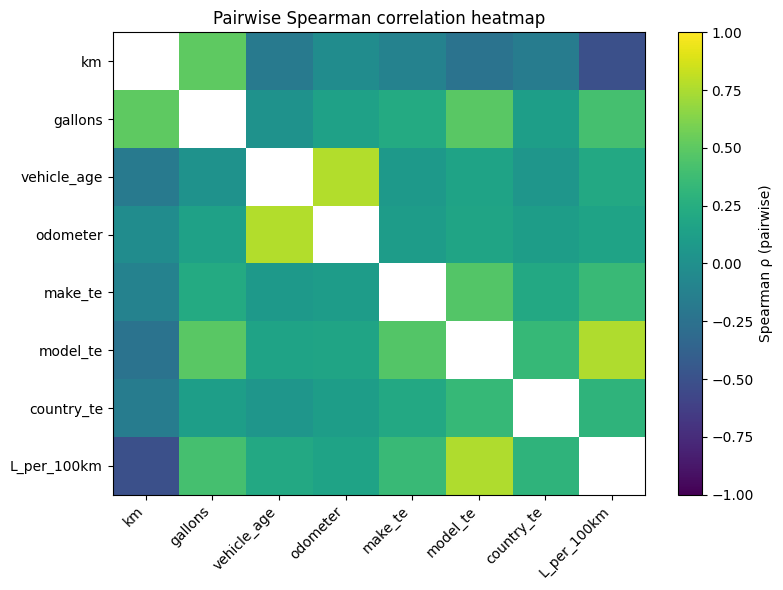

Non-null pair counts vs target (L/100km):


,n_pairs_vs_target
km,938564
gallons,938564
country_te,938564
model_te,938564
make_te,938564
vehicle_age,938451
odometer,795668
total_spent,0
cpl_local,0


In [62]:
# === 4.2.8b — Pairwise Spearman heatmap (pairwise NaN handling, matplotlib-only) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Working frame (already cleaned elsewhere)
C = df4_clean.copy() if 'df4_clean' in globals() else (D.copy() if 'D' in globals() else df.copy())

# 1) Ensure L/100km exists (compute only if missing) — local only
if 'L_per_100km' not in C.columns or C['L_per_100km'].isna().all():
    if 'liters' not in C.columns and 'gallons' in C.columns:
        US_GAL_TO_L = globals().get('US_GAL_TO_L', 3.785411784)
        C['liters'] = pd.to_numeric(C['gallons'], errors='coerce') * US_GAL_TO_L
    if 'km' not in C.columns and 'miles' in C.columns:
        C['km'] = pd.to_numeric(C['miles'], errors='coerce') * 1.609344
    if {'liters','km'}.issubset(C.columns):
        C['L_per_100km'] = pd.to_numeric(C['liters'], errors='coerce') / (
                               pd.to_numeric(C['km'], errors='coerce') / 100.0
                           )
        C.loc[~np.isfinite(C['L_per_100km']), 'L_per_100km'] = np.nan

# 2) Keep plausible efficiencies (slightly wider to preserve rows)
C = C[(C['L_per_100km'] >= 1.5) & (C['L_per_100km'] <= 35.0)]

# 3) Feature set (use what exists)
base_feats = ['km','gallons','total_spent','vehicle_age','odometer','cpl_local']
feat_cols = [c for c in base_feats if c in C.columns]

# Coerce numerics locally
for c in feat_cols:
    C[c] = pd.to_numeric(C[c], errors='coerce')

# Target-mean encodings (computed on this filtered subset to avoid leakage to junk rows)
def target_mean(df, key, target):
    if key not in df.columns or df[key].isna().all():
        return pd.Series(np.nan, index=df.index)
    return df[key].map(df.groupby(key, dropna=True)[target].mean())

if 'make' in C.columns:
    C['make_te'] = target_mean(C, 'make', 'L_per_100km'); feat_cols.append('make_te')
if 'model' in C.columns:
    C['model_te'] = target_mean(C, 'model', 'L_per_100km'); feat_cols.append('model_te')
if 'country' in C.columns:
    C['country_te'] = target_mean(C, 'country', 'L_per_100km'); feat_cols.append('country_te')

# 4) Keep features with enough pairs vs target so the heatmap isn't all NaN
def spearman_pair(df, a, b, min_n=1000):
    s = df[[a, b]].dropna()
    n = len(s)
    if n < min_n:
        return np.nan, n
    try:
        rho = s[a].corr(s[b], method='spearman')
    except Exception:
        rho = np.nan
    return rho, n

min_pairs = 1000  # adjust if you want stricter/looser inclusion
usable = []
pairs_with_target = {}
for f in feat_cols:
    rho, n = spearman_pair(C, f, 'L_per_100km', min_n=min_pairs)
    pairs_with_target[f] = n
    if not np.isnan(rho):
        usable.append(f)

cols = usable + ['L_per_100km']
if len(cols) < 2:
    print("Not enough features with sufficient non-null pairs to build a heatmap.")
else:
    # 5) Build pairwise Spearman matrix with per-cell pairwise NaN handling
    rho_mat = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for i, a in enumerate(cols):
        for j, b in enumerate(cols):
            if j < i and not pd.isna(rho_mat.iloc[j, i]):
                rho_mat.iloc[i, j] = rho_mat.iloc[j, i]  # mirror
                continue
            rho, _ = spearman_pair(C, a, b, min_n=min_pairs)
            rho_mat.iloc[i, j] = rho

    # Drop rows/cols that are all NaN (shouldn't happen if target survived)
    rho_mat = rho_mat.dropna(how='all').dropna(how='all', axis=1)

    if rho_mat.shape[0] == 0 or rho_mat.shape[1] == 0:
        print("Correlation matrix is empty after pairwise computation.")
    else:
        # 6) Plot heatmap
        plt.figure(figsize=(8, 6))
        plt.imshow(rho_mat.values, aspect='auto', vmin=-1, vmax=1)
        plt.colorbar(label='Spearman ρ (pairwise)')
        plt.xticks(range(rho_mat.shape[1]), rho_mat.columns, rotation=45, ha='right')
        plt.yticks(range(rho_mat.shape[0]), rho_mat.index)
        plt.title("Pairwise Spearman correlation heatmap")
        plt.tight_layout()
        plt.show()

        # 7) (Optional) show how many pairs each feature had with the target
        samp = (pd.Series(pairs_with_target, name='n_pairs_vs_target')
                  .sort_values(ascending=False)
                  .to_frame())
        print("Non-null pair counts vs target (L/100km):")
        display(samp)


In [ ]:
# === 4.2.9 — Random Forest: feature importances for L/100km (leakage-aware, 2 variants) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

# 0) Working frame (already cleaned elsewhere)
R = df4_clean.copy() if 'df4_clean' in globals() else (D.copy() if 'D' in globals() else df.copy())

# 1) Ensure target exists (compute only if missing) & apply a sane window
if 'L_per_100km' not in R.columns or R['L_per_100km'].isna().all():
    if 'liters' not in R.columns and 'gallons' in R.columns:
        US_GAL_TO_L = globals().get('US_GAL_TO_L', 3.785411784)
        R['liters'] = pd.to_numeric(R['gallons'], errors='coerce') * US_GAL_TO_L
    if 'km' not in R.columns and 'miles' in R.columns:
        R['km'] = pd.to_numeric(R['miles'], errors='coerce') * 1.609344
    if {'liters','km'}.issubset(R.columns):
        R['L_per_100km'] = pd.to_numeric(R['liters'], errors='coerce') / (
                               pd.to_numeric(R['km'], errors='coerce') / 100.0
                           )
        R.loc[~np.isfinite(R['L_per_100km']), 'L_per_100km'] = np.nan

# Wider but plausible window to retain rows for learning
R = R[(R['L_per_100km'] >= 1.5) & (R['L_per_100km'] <= 35.0)]

# 2) Build numeric features; coerce locally, fill with medians
def num_col(df, name):
    s = pd.to_numeric(df[name], errors='coerce') if name in df.columns else pd.Series(np.nan, index=df.index)
    # median after coercion
    med = np.nanmedian(s.values) if np.isfinite(s).any() else 0.0
    return s.fillna(med)

# Candidate numeric features
base_numeric = ['km','gallons','total_spent','vehicle_age','odometer','cpl_local']
X_base = {}
for c in base_numeric:
    if c in R.columns:
        X_base[c] = num_col(R, c)

# 3) Encodings (leakage-reduced)
y = pd.to_numeric(R['L_per_100km'], errors='coerce')

def oof_target_mean(cat_series, y, n_splits=5, min_count=25):
    """Out-of-fold target mean encoding to reduce leakage."""
    enc = pd.Series(np.nan, index=cat_series.index, dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = np.nanmean(y.values)
    for train_idx, valid_idx in kf.split(cat_series):
        tr_c = cat_series.iloc[train_idx]
        tr_y = y.iloc[train_idx]
        # compute means on the training fold
        m = tr_y.groupby(tr_c).mean()
        cnt = tr_c.value_counts()
        # shrink: categories with very small counts fall back to global mean
        m_shrunk = m.copy()
        rare_cats = cnt[cnt < min_count].index
        m_shrunk.loc[m_shrunk.index.isin(rare_cats)] = global_mean
        enc.iloc[valid_idx] = cat_series.iloc[valid_idx].map(m_shrunk).fillna(global_mean)
    # final fallback for any leftover NaNs
    enc = enc.fillna(global_mean)
    return enc

X_enc = {}

# Country frequency (simple, low leakage risk)
if 'country' in R.columns:
    freq = R['country'].value_counts(normalize=True)
    X_enc['country_freq'] = R['country'].map(freq).fillna(0.0)

# Make/model OOF mean encodings
if 'make' in R.columns:
    X_enc['make_te'] = oof_target_mean(R['make'].astype('category'), y)
if 'model' in R.columns:
    X_enc['model_te'] = oof_target_mean(R['model'].astype('category'), y)

# Assemble feature matrices
X_mech = pd.DataFrame({**X_base, **X_enc})  # includes km & gallons when present
X_behav = X_mech.drop(columns=[c for c in ['km','gallons'] if c in X_mech.columns])  # excludes mechanical parts

# Align X and y; drop any residual NaN targets
mask = y.notna()
X_mech = X_mech.loc[mask]
X_behav = X_behav.loc[mask]
y_used = y.loc[mask]

def fit_report_rf(X, y, title, n_estimators=200):
    # Drop any columns that became constant
    nunq = X.nunique()
    keep_cols = nunq[nunq > 1].index.tolist()
    X = X[keep_cols]

    if X.shape[1] == 0:
        print(f"[{title}] No usable features after filtering.")
        return None, None, None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1,
        # uncomment if you need faster training on huge data:
        # max_samples=0.5, bootstrap=True
    )
    rf.fit(X_train, y_train)
    r2 = rf.score(X_test, y_test)
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print(f"[{title}] RandomForest R^2 on holdout: {r2:.3f}")
    display(imp.head(20))

    plt.figure(figsize=(8,5))
    imp.head(15).sort_values().plot(kind='barh', edgecolor='black')
    plt.xlabel("Importance")
    plt.title(f"Random Forest — Top features ({title})")
    plt.tight_layout(); plt.show()

    return rf, imp, r2

# 4) Train & report both variants
rf_mech, imp_mech, r2_mech = fit_report_rf(X_mech, y_used, title="A: includes km & gallons")
rf_behav, imp_behav, r2_behav = fit_report_rf(X_behav, y_used, title="B: excludes km & gallons")

# 5) Quick comparison table for your PDF write-up
if imp_mech is not None and imp_behav is not None:
    comp = pd.concat([
        imp_mech.rename('A_includes_mech'),
        imp_behav.rename('B_excludes_mech')
    ], axis=1)
    print("Feature importances comparison (A vs B):")
    display(comp.fillna(0).sort_values('B_excludes_mech', ascending=False).head(20))

    print(f"R^2 comparison — A (mech): {r2_mech:.3f} | B (no mech): {r2_behav:.3f}")


/tmp/ipykernel_1441/2231834657.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = tr_y.groupby(tr_c).mean()
/tmp/ipykernel_1441/2231834657.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = tr_y.groupby(tr_c).mean()
/tmp/ipykernel_1441/2231834657.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = tr_y.groupby(tr_c).mean()
/tmp/ipykernel_1441/2231834657.py:53: FutureWarning: The default of observed=False

In [54]:
#4.3.1
cur = df["currency"].astype("string").str.strip()
sa_tokens = {"R", "ZAR"}
df_sa = df[cur.isin(sa_tokens)].copy()
print("Rows in SA dataset:", len(df_sa))
df_sa.head(10)

Rows in SA dataset: 36034


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_dt,...,cost_per_gallon_float,total_spent_float,make,model,year,user_id,litres_filled,km_driven,litres_per_100km,vehicle_age
98,Apr 5 2022,Apr 5 2022,78429.0,10.567,R73.85,R780.40,NaN,NaN,https://www.somewebsite.com/ford/transit_conne...,2022-04-05,...,73.85,780.40,ford,transit_connect,2015,1103772,48.038533,NaN,NaN,7
100,Jun 6 2013,Jun 8 2013,NaN,17.937,R47.05,R843.99,23.3,418.4000,https://www.somewebsite.com/land_rover/discove...,2013-06-06,...,47.05,843.99,land_rover,discovery,1996,123580,81.543216,673.347856,12.110117,17
197,Jan 23 2019,Feb 1 2019,169070.0,22.011,R54.59,"R1,201.47",NaN,NaN,https://www.somewebsite.com/nissan/patrol/1999...,2019-01-23,...,54.59,1201.47,nissan,patrol,1999,254197,100.063987,NaN,NaN,20
323,Aug 12 2018,Aug 4 2019,41111.0,6.763,R60.19,R407.04,40.7,275.2541,https://www.somewebsite.com/ford/ecosport/2013...,2018-08-12,...,60.19,407.04,ford,ecosport,2013,942891,30.745207,442.977433,6.940581,5
334,Jun 16 2016,Jun 16 2016,2430.0,18.011,R48.45,R872.69,15.5,279.1705,https://www.somewebsite.com/land_rover/discove...,2016-06-16,...,48.45,872.69,land_rover,discovery,2016,426622,81.879627,449.280252,18.224622,0
375,Jan 31 2022,Jan 31 2022,111820.0,17.055,R76.50,"R1,304.76",19.1,325.7505,https://www.somewebsite.com/toyota/fortuner/20...,2022-01-31,...,76.50,1304.76,toyota,fortuner,2011,445133,77.533565,524.243310,14.789615,11
393,Jun 24 2019,Jan 2 2020,42255.0,11.597,R61.17,R709.42,36.3,420.9711,https://www.somewebsite.com/audi/a3/2014/324843,2019-06-24,...,61.17,709.42,audi,a3,2014,324843,52.721006,677.485630,7.781863,5
453,Aug 15 2021,Aug 18 2021,104329.0,12.038,R59.39,R714.99,18.8,226.3144,https://www.somewebsite.com/toyota/fortuner/20...,2021-08-15,...,59.39,714.99,toyota,fortuner,2012,878394,54.725831,364.216816,15.025619,9
479,Jul 3 2015,Jul 6 2015,86194.0,7.479,R50.50,R377.67,19.9,148.8321,https://www.somewebsite.com/nissan/1400/2005/2...,2015-07-03,...,50.50,377.67,nissan,1400,2005,274539,34.000207,239.521452,14.195057,10
596,Apr 15 2016,Apr 15 2016,74699.0,8.704,R45.96,R399.99,NaN,NaN,https://www.somewebsite.com/volkswagen/citi/20...,2016-04-15,...,45.96,399.99,volkswagen,citi,2007,378050,39.569167,NaN,NaN,9


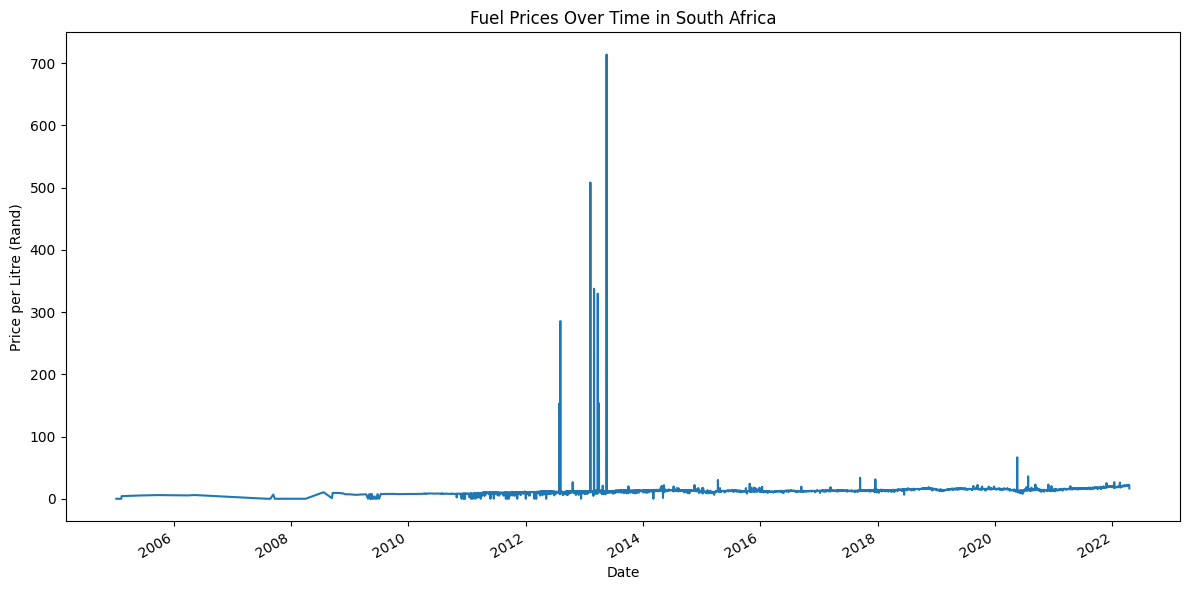

In [55]:
#4.3.2
#1 gallon = 3.785 litres, convert to Rand per litre
df_sa["price_per_litre"] = df_sa["cost_per_gallon_float"] / 3.785
daily_prices = df_sa.groupby("date_fueled_dt")["price_per_litre"].mean()
plt.figure(figsize=(12,6))
daily_prices.plot()
plt.title("Fuel Prices Over Time in South Africa")
plt.xlabel("Date")
plt.ylabel("Price per Litre (Rand)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1441/4142069989.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("weekday")["user_id"]


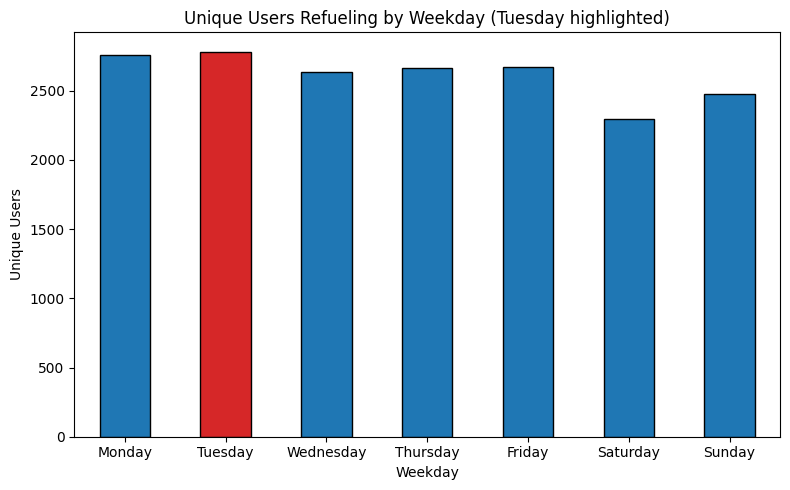

weekday
Monday       2759
Tuesday      2782
Wednesday    2631
Thursday     2666
Friday       2673
Saturday     2294
Sunday       2479
Name: user_id, dtype: int64


In [56]:
#4.3.3
df_sa["weekday"] = df_sa["date_fueled_dt"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_sa["weekday"] = pd.Categorical(df_sa["weekday"], categories=order, ordered=True)


counts = (
    df_sa.dropna(subset=["user_id"])
         .groupby("weekday")["user_id"]
         .nunique()
         .reindex(order)
)


colors = ["tab:blue" if d != "Tuesday" else "tab:red" for d in counts.index]

plt.figure(figsize=(8,5))
counts.plot(kind="bar", color=colors, edgecolor="black")
plt.title("Unique Users Refueling by Weekday (Tuesday highlighted)")
plt.xlabel("Weekday")
plt.ylabel("Unique Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(counts)

In [57]:
#4.3.4
if "df_sa" not in globals():
    sa_tokens = {"R", "ZAR"}
    df_sa = df[df["currency"].astype("string").str.strip().isin(sa_tokens)].copy()

if "date_fueled_dt" not in df_sa.columns or not pd.api.types.is_datetime64_any_dtype(df_sa["date_fueled_dt"]):
    df_sa["date_fueled_dt"] = pd.to_datetime(df_sa["date_fueled"], errors="coerce", dayfirst=False)


tmp = df_sa.copy()
tmp["month"] = tmp["date_fueled_dt"].dt.to_period("M")
tmp["weekday_num"] = tmp["date_fueled_dt"].dt.weekday     
tmp["day"] = tmp["date_fueled_dt"].dt.day


first_tue_wed = (
    tmp[tmp["weekday_num"].isin([1, 2])]
      .groupby(["month", "weekday_num"], observed=True)["day"]
      .min()
      .reset_index()
)

df_sa_first = tmp.merge(first_tue_wed, on=["month", "weekday_num", "day"], how="inner")


df_sa_first = df_sa_first.drop(columns=["month"]).sort_values("date_fueled_dt").reset_index(drop=True)

print(f"Rows in SA (all): {len(df_sa)}")
print(f"Rows on 1st Tue/Wed per month: {len(df_sa_first)}")
df_sa_first[["date_fueled_dt", "weekday_num", "currency", "user_id"]].head(20)

Rows in SA (all): 36034
Rows on 1st Tue/Wed per month: 2991


,date_fueled_dt,weekday_num,currency,user_id
0,2005-02-09,2,R,63822
1,2006-02-14,1,R,134608
2,2006-03-14,1,R,134608
3,2008-01-02,2,R,31017
4,2008-03-04,1,R,31017
5,2008-04-01,1,R,31017
6,2008-07-22,1,R,132066
7,2008-09-17,2,R,132066
8,2008-10-28,1,R,132066
9,2008-11-04,1,R,132066


In [58]:
#4.3.5

first_tue_wed = (
    tmp[tmp["weekday_num"].isin([1, 2])]
      .groupby(["month", "weekday_num"], observed=True)["day"]
      .min()
      .reset_index()
)


df_sa_first = tmp.merge(first_tue_wed, on=["month", "weekday_num", "day"], how="inner")

price_trends = (
    df_sa_first.groupby(["month", "weekday_num"])["cost_per_gallon_float"]
               .mean()
               .unstack()  
)


price_trends["trend"] = np.where(price_trends[2] > price_trends[1], "up", "down")

df_sa_first = df_sa_first.merge(price_trends["trend"], on="month", how="left")

df_sa_first[["date_fueled_dt", "weekday_num", "cost_per_gallon_float", "trend"]].head(12)

,date_fueled_dt,weekday_num,cost_per_gallon_float,trend
0,2022-04-05,1,73.85,up
1,2017-08-01,1,43.80,up
2,2018-03-07,2,52.09,down
3,2022-03-02,2,79.46,up
4,2019-04-02,1,55.27,up
5,2014-11-05,2,49.14,down
6,2021-10-06,2,66.66,down
7,2021-02-02,1,53.83,up
8,2021-10-06,2,68.55,down
9,2016-06-01,2,47.85,down


Refuelling on 1st Wednesday of month:
trend
down    381
up      605
Name: user_id, dtype: int64


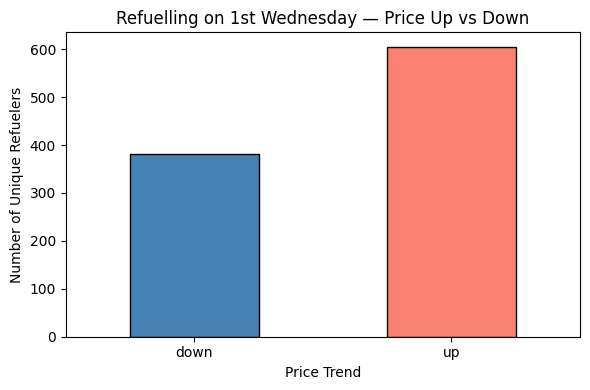

In [59]:
#4.3.6

wed_df = df_sa_first[df_sa_first["weekday_num"] == 2]

wed_counts = wed_df.groupby("trend")["user_id"].nunique()

print("Refuelling on 1st Wednesday of month:")
print(wed_counts)

plt.figure(figsize=(6,4))
wed_counts.plot(kind="bar", color=["steelblue", "salmon"], edgecolor="black")
plt.title("Refuelling on 1st Wednesday — Price Up vs Down")
plt.xlabel("Price Trend")
plt.ylabel("Number of Unique Refuelers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Refuelling on 1st Tuesday of month:
trend
down     335
up      1146
Name: user_id, dtype: int64


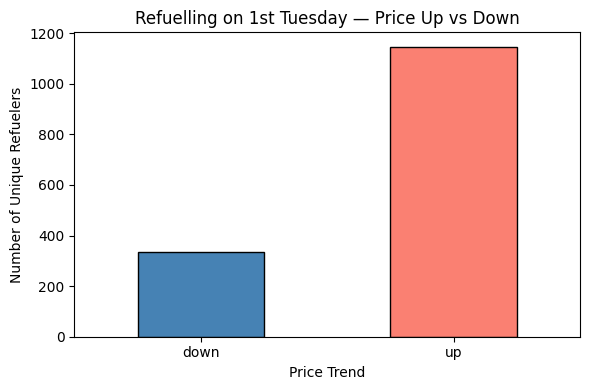

In [60]:
# 4.3.7 
tue_df = df_sa_first[df_sa_first["weekday_num"] == 1]

tue_counts = tue_df.groupby("trend")["user_id"].nunique()

print("Refuelling on 1st Tuesday of month:")
print(tue_counts)

plt.figure(figsize=(6,4))
tue_counts.plot(kind="bar", color=["steelblue", "salmon"], edgecolor="black")
plt.title("Refuelling on 1st Tuesday — Price Up vs Down")
plt.xlabel("Price Trend")
plt.ylabel("Number of Unique Refuelers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()